In [1]:
from collections import defaultdict
import itertools
import jax
import numpy as np

from benchmark import benchmark_chains, cumulative_avg, err, ess, get_num_latents
import blackjax
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
from blackjax.mcmc.mhmclmc import rescale
from blackjax.util import run_inference_algorithm
import jax.numpy as jnp 

from inference_models import models
from find_params import make_grid, sampler_mhmclmc



In [18]:


batch_size = 1000
num_steps = 10000

results = defaultdict(float)
for model in ["banana"]:
    # for step_size, L in itertools.product([16.866055/10], [16.866055]):
    # for step_size, L in make_grid(center_L=21.48713, center_step_size= 2.2340074):

    # center_step_size = 2.2340074
    # center_L = 21.48713

    center_step_size = 1.1170037
    center_L = 12.776323938494208

    # center_step_size = 1.2332720719048489
    # center_L = 11.86185745597299

    # center_step_size =  1.1170037
    # center_L = 10.743564999999998
    
    for step_size, L in itertools.product(np.logspace(np.log10(center_step_size/2), np.log10(center_step_size*2), 9), np.logspace(np.log10(center_L/2), np.log10(center_L*2), 9)):


    # for sampler in ["mhmclmc"]:
        # result, bias = benchmark_chains(models[model], sampler_mhmclmc_with_tuning(step_size, L), n=1000000, batch=1)
        # result, bias = benchmark_chains(models[model], samplers[sampler], n=100000, batch=100, favg= jnp.array([100.0, 19.0]), fvar =jnp.array([20000.0, 4600.898]))
        result, bias = benchmark_chains(models[model], sampler_mhmclmc(step_size=step_size, L=L), batch=batch_size, n=num_steps,favg=models[model].E_x2, fvar=models[model].Var_x2)
        # result, bias = benchmark_chains(models[model], samplers["mhmclmc"], n=1000000, batch=10)
        results[(model, step_size, L)] = (result.item(), bias.item())


In [15]:
import bayex


def benchmark_chains_prime(model, sampler, favg, fvar, n=10000, batch=None):


    # print(model)
    # print(model.sample_transformations.keys())
    # raise Exception
    identity_fn = model.sample_transformations['identity']
    logdensity_fn = model.unnormalized_log_prob
    d = get_num_latents(model)
    if batch is None:
        batch = np.ceil(1000 / d).astype(int)
    key, init_key = jax.random.split(jax.random.PRNGKey(42), 2)
    keys = jax.random.split(key, batch)
    # keys = jnp.array([jax.random.PRNGKey(0)])
    init_pos = jax.random.normal(key=init_key, shape=(batch, d))

    samples, params, avg_num_steps_per_traj = jax.vmap(lambda pos, key: sampler(logdensity_fn, n, pos, key))(init_pos, keys)
    avg_num_steps_per_traj = jnp.mean(avg_num_steps_per_traj, axis=0)
    print("\n\n\n\nAVG NUM STEPS PER TRAJ", avg_num_steps_per_traj)
    # print(samples[0][-1], samples[0][0], "samps chain", samples.shape)
              
        # identity_fn.ground_truth_mean, identity_fn.ground_truth_standard_deviation**2
    full = lambda arr : err(favg, fvar, jnp.average)(cumulative_avg(arr))
    err_t = jnp.mean(jax.vmap(full)(samples**2), axis=0)
    # ess_per_sample = ess(err_t, grad_evals_per_step=2 * avg_num_steps_per_traj)
    # err_t = jax.vmap(full)(samples)[1]
    # print(err_t[-1], "benchmark chains err_t[0]")
    # print(avg_num_steps_per_traj, "AVG\n\n")
    # raise Exception
    # ess_per_sample = ess(err_t, grad_evals_per_step=2 * avg_num_steps_per_traj)

    print('True mean', identity_fn.ground_truth_mean)
    print('True std', identity_fn.ground_truth_standard_deviation)
    print("Empirical mean", samples.mean(axis=[0,1]))
    print("Empirical std", samples.std(axis=[0,1]))

    print(params.L.mean(), params.step_size.mean(), "params")
    
    # print('True E[x^2]', identity_fn.ground_truth_mean)
    # print('True std[x^2]', identity_fn.ground_truth_standard_deviation)

    return err_t[-1]

def f(step_size, L):
    model = "banana"
    # print(type(step_size), type(L))
    # raise Exception
    traj_length = L/step_size
    bias = benchmark_chains_prime(models[model], sampler_mhmclmc(step_size, L), batch=100, n=4000,favg=models[model].E_x2, fvar=models[model].Var_x2)
    return - (bias * traj_length)

constrains = {'step_size': (0.9, 2.), 'L': (10., 30.)}
optim_params = bayex.optim(f, constrains=constrains, seed=42, n=100)


Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[100])>with<BatchTrace(level=1/0)> with
    val = Array([[0.8435858 , 0.8442986 , 0.8415559 , 0.8427685 , 0.8463157 ,
        0.8491128 , 0.8431078 , 0.84260917, 0.84483224, 0.8375843 ,
        0.8375893 , 0.8419349 , 0.84908915, 0.84480864, 0.8410134 ,
        0.8449966 , 0.84187603, 0.845713  , 0.8447011 , 0.84466696,
        0.8400421 , 0.84705085, 0.8332738 , 0.84576803, 0.8336657 ,
        0.84211314, 0.8455844 , 0.8392147 , 0.8509331 , 0.8440238 ,
        0.8371414 , 0.8386296 , 0.8451284 , 0.848194  , 0.8394416 ,
        0.8498367 , 0.8330134 , 0.84099394, 0.8421177 , 0.843717  ,
        0.84450364, 0.8514319 , 0.8448533 , 0.84387785, 0.8439756 ,
        0.83963746, 0.8402315 , 0.85167474, 0.84031194, 0.84450245,
        0.8455862 , 0.84251726, 0.8467568 , 0.8340951 , 0.8407393 ,
        0.84303313, 0.8486856 , 0.8418433 , 0.84375656, 0.84481865,
        0.84720576, 0.8517645 , 0.83


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8261169 , 0.8235434 , 0.82660365, 0.8363452 , 0.8260836 ,
       0.8221712 , 0.8335143 , 0.8315658 , 0.82896984, 0.828555  ,
       0.8154472 , 0.8228515 , 0.8359856 , 0.82363015, 0.8356578 ,
       0.83509433, 0.8286654 , 0.83434707, 0.81034994, 0.8310843 ,
       0.8242507 , 0.8322238 , 0.81031936, 0.82537174, 0.82792544,
       0.82657754, 0.8337225 , 0.8175826 , 0.836278  , 0.8194272 ,
       0.8321048 , 0.82484585, 0.8270816 , 0.8372117 , 0.8253429 ,
       0.8327278 , 0.82710975, 0.8298831 , 0.8243826 , 0.83905584,
       0.829383  , 0.8279811 , 0.82872564, 0.8276056 , 0.8262757 ,
       0.82485056, 0.838198  , 0.8324125 , 0.8215901 , 0.8233186 ,
       0.82139015, 0.8307298 , 0.8249091 , 0.8366107 , 0.8180485 ,
       0.82277554, 0.83015084, 0.816568  , 0.82515043, 0.81732994,
       0.82909644, 0.8383716 , 0.8324836 , 0.8359744 , 0.8320422 ,
       0.8294888 , 0.82825166, 0.8239016 , 0.8114942 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7624757 , 0.7732598 , 0.77196664, 0.7618297 , 0.7726041 ,
       0.7745761 , 0.77812725, 0.76879174, 0.7801456 , 0.7776064 ,
       0.7700916 , 0.7750695 , 0.77436024, 0.7656311 , 0.76576954,
       0.7802393 , 0.7809813 , 0.770915  , 0.76499385, 0.7689456 ,
       0.7648939 , 0.7784399 , 0.7776192 , 0.7831998 , 0.7677948 ,
       0.77016276, 0.7881546 , 0.77732486, 0.77114564, 0.77909887,
       0.7719862 , 0.77378213, 0.7766315 , 0.77503484, 0.77038395,
       0.76448816, 0.7696017 , 0.7634618 , 0.77056473, 0.7741178 ,
       0.7737147 , 0.77556324, 0.77876955, 0.77788526, 0.7759326 ,
       0.7691555 , 0.76327246, 0.77293766, 0.7730725 , 0.77486354,
       0.7707382 , 0.77392834, 0.77476096, 0.7698485 , 0.77451026,
       0.77709085, 0.7751241 , 0.77147466, 0.7727592 , 0.76727945,
       0.7758949 , 0.765997  , 0.77851874, 0.7683197 , 0.77228504,
       0.7603619 , 0.77689904, 0.7759391 , 0.766344  , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7438637 , 0.720913  , 0.74190116, 0.73635954, 0.7341818 ,
       0.7309659 , 0.74363166, 0.72856337, 0.7287968 , 0.7244966 ,
       0.7381871 , 0.7292842 , 0.7322443 , 0.7441796 , 0.7321374 ,
       0.73585445, 0.73341906, 0.7292971 , 0.734212  , 0.723085  ,
       0.72761494, 0.72691494, 0.738055  , 0.744325  , 0.750554  ,
       0.7395077 , 0.7374884 , 0.73136467, 0.7343612 , 0.74693364,
       0.7242545 , 0.7310544 , 0.72981083, 0.7308932 , 0.7355907 ,
       0.73518115, 0.72772306, 0.7237244 , 0.745851  , 0.7330887 ,
       0.74185824, 0.7326187 , 0.7284662 , 0.74228776, 0.7386332 ,
       0.7308844 , 0.73114395, 0.72271717, 0.73372227, 0.73718625,
       0.73117095, 0.731803  , 0.73584557, 0.73563296, 0.7423742 ,
       0.7256776 , 0.74184483, 0.73792344, 0.7324871 , 0.7299209 ,
       0.7364746 , 0.73932797, 0.7306512 , 0.74121165, 0.74229944,
       0.72620326, 0.7356973 , 0.7370564 , 0.7296387 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.86778754, 0.8646974 , 0.8777796 , 0.86214703, 0.86671984,
       0.86888176, 0.87431735, 0.8680127 , 0.8682585 , 0.86737514,
       0.869242  , 0.8713519 , 0.8700291 , 0.8725032 , 0.8693933 ,
       0.8719237 , 0.87480927, 0.8702645 , 0.8764573 , 0.86809504,
       0.87091154, 0.873827  , 0.8701522 , 0.87577397, 0.8707997 ,
       0.8719032 , 0.8734054 , 0.8697026 , 0.8752431 , 0.8730436 ,
       0.87251914, 0.86377573, 0.86697793, 0.8669683 , 0.87357634,
       0.8726103 , 0.8727115 , 0.8671376 , 0.8774689 , 0.8754535 ,
       0.8721305 , 0.8725799 , 0.87109244, 0.870204  , 0.8702406 ,
       0.86980313, 0.86733603, 0.86205685, 0.8747727 , 0.8665746 ,
       0.87257814, 0.872714  , 0.86964357, 0.8695413 , 0.8696763 ,
       0.8678582 , 0.87303984, 0.8699697 , 0.87240916, 0.87506926,
       0.87008125, 0.86404115, 0.86860496, 0.8714165 , 0.86788106,
       0.8680976 , 0.8683646 , 0.8721114 , 0.8673468 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9646462 , 0.96441925, 0.963197  , 0.9641055 , 0.9641592 ,
       0.9646159 , 0.9649835 , 0.9644888 , 0.9647308 , 0.9653222 ,
       0.96523523, 0.9630228 , 0.96286917, 0.9636026 , 0.9622946 ,
       0.96522623, 0.96535504, 0.96068555, 0.96405786, 0.9645421 ,
       0.96359646, 0.9637924 , 0.9629329 , 0.9654972 , 0.9632747 ,
       0.9641683 , 0.9651973 , 0.9633302 , 0.9666546 , 0.9669899 ,
       0.965569  , 0.965853  , 0.96334577, 0.9650977 , 0.9619848 ,
       0.96419644, 0.96265894, 0.96560556, 0.9662199 , 0.96514744,
       0.966319  , 0.9632063 , 0.9634584 , 0.9641959 , 0.9654187 ,
       0.9623485 , 0.96521956, 0.96475565, 0.9636724 , 0.964506  ,
       0.96508974, 0.96484804, 0.9640583 , 0.9649708 , 0.96188015,
       0.9611353 , 0.964087  , 0.9648015 , 0.96420103, 0.9641244 ,
       0.9634837 , 0.9659584 , 0.96390843, 0.96480024, 0.96147716,
       0.96349597, 0.96449476, 0.96483   , 0.9632044 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9657846 , 0.9654158 , 0.96737653, 0.96326333, 0.964079  ,
       0.9656495 , 0.96491003, 0.96374923, 0.9646414 , 0.96449995,
       0.9643607 , 0.9600758 , 0.9663494 , 0.9656496 , 0.966745  ,
       0.9685083 , 0.96543515, 0.9664908 , 0.9655981 , 0.9683824 ,
       0.96335167, 0.96440417, 0.9648844 , 0.96654105, 0.96724683,
       0.9681661 , 0.96706396, 0.9640292 , 0.9656866 , 0.9657853 ,
       0.9639722 , 0.9641251 , 0.966178  , 0.9662001 , 0.96563596,
       0.9659677 , 0.9644174 , 0.9655367 , 0.9655435 , 0.96505255,
       0.96729535, 0.9667774 , 0.96322817, 0.9658592 , 0.96720624,
       0.96409464, 0.964196  , 0.9649782 , 0.9674235 , 0.9651824 ,
       0.9653462 , 0.9647231 , 0.9643931 , 0.96227235, 0.96143144,
       0.96449405, 0.9654843 , 0.96483666, 0.9646436 , 0.96516716,
       0.96560585, 0.9656106 , 0.9675184 , 0.965978  , 0.96644974,
       0.9663985 , 0.9638768 , 0.96604615, 0.9649481 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7405754 , 0.7306312 , 0.73310345, 0.7388016 , 0.7392493 ,
       0.7471283 , 0.7485748 , 0.74139786, 0.73972803, 0.73189986,
       0.7379276 , 0.7396708 , 0.7181681 , 0.73423505, 0.737977  ,
       0.73418534, 0.7364122 , 0.7272365 , 0.7368498 , 0.7455538 ,
       0.73279995, 0.7351176 , 0.7317533 , 0.7430141 , 0.7406916 ,
       0.7399521 , 0.73158306, 0.73081595, 0.7355946 , 0.72891957,
       0.7279601 , 0.7342506 , 0.739928  , 0.7539356 , 0.7371102 ,
       0.7437107 , 0.7439878 , 0.7354035 , 0.735965  , 0.72090495,
       0.7407755 , 0.7365683 , 0.74429667, 0.7317289 , 0.71507514,
       0.7227194 , 0.7455055 , 0.7361995 , 0.7509387 , 0.73579943,
       0.7413889 , 0.74201417, 0.726448  , 0.7403964 , 0.7453037 ,
       0.7382096 , 0.7462251 , 0.727476  , 0.7505474 , 0.7466791 ,
       0.73478127, 0.7423563 , 0.73530143, 0.7420538 , 0.7424166 ,
       0.7507166 , 0.7458518 , 0.7429123 , 0.70983547, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.6686791 , 0.6692744 , 0.658693  , 0.6572771 , 0.65694696,
       0.6562955 , 0.6578111 , 0.662403  , 0.6653719 , 0.6568161 ,
       0.6708718 , 0.6729646 , 0.661823  , 0.6647983 , 0.6667355 ,
       0.66000384, 0.6732394 , 0.6699426 , 0.6596668 , 0.6612171 ,
       0.6497439 , 0.6691632 , 0.6672595 , 0.6623486 , 0.62033   ,
       0.6677552 , 0.6440937 , 0.6440927 , 0.67481035, 0.6648804 ,
       0.6628258 , 0.66647583, 0.66873354, 0.6684244 , 0.66616744,
       0.6618645 , 0.6595272 , 0.6466183 , 0.6537556 , 0.6717985 ,
       0.6569731 , 0.66440547, 0.6592092 , 0.6691215 , 0.6642743 ,
       0.65359783, 0.6516272 , 0.65598416, 0.6694276 , 0.67428386,
       0.66649854, 0.66296583, 0.66491127, 0.6486725 , 0.6666575 ,
       0.6592822 , 0.66131085, 0.6516573 , 0.6623106 , 0.65817934,
       0.66456974, 0.6687929 , 0.6452302 , 0.65796876, 0.6595185 ,
       0.674048  , 0.66439176, 0.6630273 , 0.67858857, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.955858  , 0.9571745 , 0.9537277 , 0.9552592 , 0.9543102 ,
       0.9573221 , 0.9556906 , 0.9555991 , 0.9583533 , 0.9574764 ,
       0.95407724, 0.95405185, 0.95703614, 0.95465434, 0.95641345,
       0.9572647 , 0.95462894, 0.9553996 , 0.95355296, 0.9552221 ,
       0.9529672 , 0.9547226 , 0.95235366, 0.95583457, 0.95620865,
       0.9574142 , 0.9551745 , 0.95658565, 0.9540315 , 0.9572223 ,
       0.9560699 , 0.9550011 , 0.9564879 , 0.9583723 , 0.9554788 ,
       0.95413095, 0.95573795, 0.95418954, 0.9559964 , 0.9567973 ,
       0.9543665 , 0.95349985, 0.95723325, 0.9569616 , 0.9551863 ,
       0.95471364, 0.95660967, 0.956237  , 0.95568544, 0.9560728 ,
       0.9557498 , 0.9562172 , 0.95290446, 0.9559223 , 0.953645  ,
       0.95541555, 0.95647633, 0.95328635, 0.9565374 , 0.95762706,
       0.9576281 , 0.9505903 , 0.9561318 , 0.9562256 , 0.95540094,
       0.9553004 , 0.95369977, 0.95491284, 0.95438224, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.96264863, 0.9634886 , 0.9654491 , 0.96161014, 0.9646267 ,
       0.96197766, 0.9637073 , 0.964096  , 0.9642366 , 0.962025  ,
       0.96133184, 0.96301097, 0.96350014, 0.96281374, 0.96277064,
       0.9660417 , 0.96478313, 0.9611292 , 0.96175057, 0.9641598 ,
       0.96387273, 0.9623814 , 0.963368  , 0.96224064, 0.9639983 ,
       0.9642765 , 0.96539843, 0.961065  , 0.96363866, 0.96541387,
       0.9627818 , 0.9658572 , 0.9633118 , 0.9621093 , 0.9626922 ,
       0.96371615, 0.9627704 , 0.9632583 , 0.96245104, 0.96418244,
       0.9637416 , 0.9613277 , 0.9621408 , 0.96529937, 0.96559614,
       0.96179414, 0.9614394 , 0.96268296, 0.96477133, 0.96407413,
       0.9638706 , 0.96270704, 0.96164525, 0.9651497 , 0.9636932 ,
       0.9608916 , 0.9636057 , 0.9632236 , 0.9633536 , 0.9641617 ,
       0.9623775 , 0.9617653 , 0.9632366 , 0.9648417 , 0.9630716 ,
       0.96513605, 0.96552825, 0.9624096 , 0.9654092 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.95152754, 0.9528256 , 0.9499533 , 0.9514191 , 0.9500468 ,
       0.95024854, 0.95125955, 0.9538696 , 0.95289403, 0.9518052 ,
       0.9510819 , 0.95306695, 0.95162505, 0.95049566, 0.9499518 ,
       0.94938666, 0.95587397, 0.95113283, 0.9504822 , 0.9509464 ,
       0.9503298 , 0.9529286 , 0.95327294, 0.9498845 , 0.9535273 ,
       0.95398986, 0.95080525, 0.94865364, 0.9546818 , 0.9536086 ,
       0.95196694, 0.95205766, 0.9519836 , 0.9515288 , 0.9520121 ,
       0.9498969 , 0.95035845, 0.94861674, 0.9560071 , 0.9505284 ,
       0.95206445, 0.9520732 , 0.9498783 , 0.9507284 , 0.95180523,
       0.9493862 , 0.9518956 , 0.9497572 , 0.9521449 , 0.95403945,
       0.95129937, 0.95126253, 0.9482311 , 0.95055366, 0.9541053 ,
       0.95079947, 0.94959766, 0.95223993, 0.9540765 , 0.94781595,
       0.95128936, 0.9504917 , 0.9519002 , 0.9521846 , 0.95198876,
       0.9553459 , 0.9524388 , 0.95287216, 0.9502836 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.952894  , 0.95669156, 0.95403475, 0.9532773 , 0.9515213 ,
       0.9545166 , 0.9537186 , 0.9551645 , 0.9531748 , 0.95276606,
       0.95450014, 0.95240116, 0.9535121 , 0.9540095 , 0.95531774,
       0.9569585 , 0.95240825, 0.9562255 , 0.9528611 , 0.95109206,
       0.95348537, 0.9556493 , 0.95448864, 0.95620644, 0.95481604,
       0.95397353, 0.9541744 , 0.9532906 , 0.95449203, 0.954691  ,
       0.95683634, 0.9527385 , 0.9525758 , 0.95468634, 0.9521879 ,
       0.95586807, 0.95348734, 0.9538922 , 0.95289207, 0.95270133,
       0.9563371 , 0.9567262 , 0.9536751 , 0.95455325, 0.9544427 ,
       0.9519152 , 0.9541748 , 0.95142657, 0.9560434 , 0.9541932 ,
       0.9542864 , 0.9533105 , 0.95391953, 0.9552938 , 0.9553616 ,
       0.95555365, 0.9542001 , 0.9532726 , 0.95520645, 0.9534117 ,
       0.9557604 , 0.95367754, 0.9542548 , 0.95274407, 0.9538156 ,
       0.9537166 , 0.9556495 , 0.9546571 , 0.95565885, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.97797734, 0.97769815, 0.97931457, 0.9790263 , 0.979551  ,
       0.9794091 , 0.9782542 , 0.9770757 , 0.97934586, 0.97946817,
       0.97700614, 0.9770652 , 0.9760228 , 0.97916335, 0.9773072 ,
       0.9770723 , 0.977769  , 0.9754941 , 0.97799706, 0.9805394 ,
       0.97647226, 0.9786254 , 0.97838473, 0.9776399 , 0.97828895,
       0.9796769 , 0.9782391 , 0.9775556 , 0.9802075 , 0.97926056,
       0.9796683 , 0.9779927 , 0.9759681 , 0.9787986 , 0.97915804,
       0.9788852 , 0.97864103, 0.97813684, 0.9781977 , 0.9790235 ,
       0.9773111 , 0.97693586, 0.97727203, 0.98116624, 0.9788685 ,
       0.97757804, 0.9792123 , 0.9781032 , 0.9779511 , 0.97851723,
       0.9790129 , 0.978772  , 0.9767028 , 0.978689  , 0.97772366,
       0.9784057 , 0.9777687 , 0.97701275, 0.9764907 , 0.9776689 ,
       0.9789163 , 0.9806707 , 0.97947687, 0.9794806 , 0.97846043,
       0.98031276, 0.97873163, 0.976569  , 0.9786465 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9706634 , 0.97098666, 0.9694601 , 0.9681498 , 0.9700269 ,
       0.967197  , 0.9705881 , 0.969211  , 0.9699975 , 0.9692914 ,
       0.9693561 , 0.9678726 , 0.9699439 , 0.97092956, 0.9698238 ,
       0.9686026 , 0.9714447 , 0.96734333, 0.97035784, 0.9694195 ,
       0.97120696, 0.9670112 , 0.97104776, 0.9687568 , 0.97024584,
       0.9700105 , 0.9665923 , 0.9681051 , 0.9717239 , 0.97056866,
       0.97021514, 0.96890116, 0.9687969 , 0.9699899 , 0.9701967 ,
       0.9687107 , 0.9684911 , 0.9675959 , 0.968705  , 0.9711248 ,
       0.9713141 , 0.9697411 , 0.96827996, 0.97009856, 0.9713252 ,
       0.9691815 , 0.96876496, 0.9672972 , 0.9695717 , 0.9656774 ,
       0.9702509 , 0.9679051 , 0.968466  , 0.96958756, 0.9697638 ,
       0.9695184 , 0.9673462 , 0.96857166, 0.9677763 , 0.968722  ,
       0.96942043, 0.9703901 , 0.971012  , 0.9703512 , 0.97234964,
       0.9706861 , 0.9706261 , 0.9711099 , 0.96833515, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.765001  , 0.77106005, 0.766231  , 0.7573349 , 0.7637333 ,
       0.7630885 , 0.7568375 , 0.7640093 , 0.7641316 , 0.7636318 ,
       0.7597957 , 0.75792915, 0.75555027, 0.76914364, 0.76639336,
       0.76318353, 0.7698728 , 0.74840224, 0.7471755 , 0.7696125 ,
       0.76830167, 0.7534192 , 0.7636392 , 0.7691061 , 0.77108085,
       0.75860226, 0.7648175 , 0.76404065, 0.76411223, 0.77413213,
       0.7582009 , 0.7683605 , 0.7545073 , 0.77713865, 0.75450885,
       0.76261204, 0.7641284 , 0.7624106 , 0.7678965 , 0.75622094,
       0.7479578 , 0.7742349 , 0.7592671 , 0.76301926, 0.7768186 ,
       0.7631453 , 0.7614084 , 0.7599505 , 0.7694386 , 0.76579094,
       0.7596896 , 0.7682055 , 0.7476718 , 0.7612631 , 0.7652557 ,
       0.7679862 , 0.7694422 , 0.7612729 , 0.7771715 , 0.76277846,
       0.76831686, 0.7586822 , 0.75014037, 0.7490575 , 0.75217104,
       0.7691096 , 0.75744194, 0.75607526, 0.7563565 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9744522 , 0.97190344, 0.9730079 , 0.97074765, 0.9741525 ,
       0.97398394, 0.9726597 , 0.9744511 , 0.97214746, 0.9752701 ,
       0.9720341 , 0.9719287 , 0.9722756 , 0.9740282 , 0.9742127 ,
       0.97417426, 0.973794  , 0.97219473, 0.9719966 , 0.9745573 ,
       0.9746508 , 0.973063  , 0.9727895 , 0.97202754, 0.97012985,
       0.97573626, 0.97474796, 0.9710071 , 0.97359174, 0.97536856,
       0.971808  , 0.9738891 , 0.9692668 , 0.9734631 , 0.9754216 ,
       0.9739054 , 0.974118  , 0.9739694 , 0.97258216, 0.97312343,
       0.97578317, 0.97261524, 0.97113234, 0.96924704, 0.9744146 ,
       0.9730488 , 0.97405314, 0.9720641 , 0.9722286 , 0.9717402 ,
       0.9748945 , 0.97243893, 0.9726811 , 0.9729702 , 0.9741779 ,
       0.97193676, 0.9715692 , 0.9737768 , 0.9711003 , 0.9748577 ,
       0.9745163 , 0.9740224 , 0.9711838 , 0.97291684, 0.9746379 ,
       0.9747121 , 0.9753206 , 0.97192514, 0.9727889 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.87744623, 0.88013846, 0.8835956 , 0.8790409 , 0.87804157,
       0.8833443 , 0.8819389 , 0.8794167 , 0.87933224, 0.88456696,
       0.884324  , 0.8804126 , 0.88113624, 0.8828332 , 0.8788626 ,
       0.88094443, 0.88706845, 0.88163173, 0.8804915 , 0.8830209 ,
       0.87504697, 0.8828043 , 0.8820411 , 0.88777435, 0.88384604,
       0.88534063, 0.87888306, 0.88043594, 0.88281405, 0.8832786 ,
       0.8718075 , 0.88513017, 0.88497496, 0.8844917 , 0.8828935 ,
       0.885611  , 0.8843868 , 0.88674414, 0.8799652 , 0.87798494,
       0.89279896, 0.88683844, 0.8688099 , 0.88137203, 0.885329  ,
       0.8827274 , 0.88338804, 0.8816547 , 0.88510454, 0.86871636,
       0.88377064, 0.88592386, 0.87905204, 0.8816537 , 0.88444227,
       0.8868649 , 0.8844417 , 0.8822226 , 0.8790195 , 0.8829306 ,
       0.8827547 , 0.88246256, 0.89191085, 0.8838837 , 0.8856683 ,
       0.88628876, 0.88498425, 0.88318014, 0.87706316, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.906803  , 0.90908176, 0.9084152 , 0.90833575, 0.90746355,
       0.91063356, 0.9087737 , 0.909748  , 0.9105888 , 0.9071666 ,
       0.90712756, 0.90743816, 0.9079251 , 0.9039106 , 0.9068635 ,
       0.9113365 , 0.9090463 , 0.9029339 , 0.90839374, 0.9136048 ,
       0.90904987, 0.9051489 , 0.905732  , 0.90776753, 0.9107171 ,
       0.908334  , 0.9113236 , 0.9033993 , 0.9125853 , 0.9129885 ,
       0.9080643 , 0.90394175, 0.9092255 , 0.91356343, 0.90777475,
       0.91062224, 0.90954787, 0.9089876 , 0.90811974, 0.90925986,
       0.9113398 , 0.9102961 , 0.90677774, 0.90574104, 0.9066503 ,
       0.9059078 , 0.9145122 , 0.91294885, 0.9119237 , 0.90832055,
       0.9075463 , 0.91392946, 0.9081092 , 0.9102902 , 0.9104273 ,
       0.9042802 , 0.91067445, 0.9086453 , 0.9103653 , 0.90850884,
       0.9064013 , 0.90941155, 0.91122013, 0.91143095, 0.9102971 ,
       0.91178656, 0.9092924 , 0.9131262 , 0.90565175, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.87874794, 0.88156533, 0.8779272 , 0.8756458 , 0.8772155 ,
       0.88527054, 0.87923896, 0.882713  , 0.8835349 , 0.88135356,
       0.8792225 , 0.8775871 , 0.87867826, 0.8771506 , 0.8744516 ,
       0.87950337, 0.8743665 , 0.87677246, 0.8755074 , 0.87708193,
       0.87670815, 0.8745238 , 0.8809091 , 0.87830764, 0.87780315,
       0.8826204 , 0.8756022 , 0.8800733 , 0.88041276, 0.87621   ,
       0.8814042 , 0.88052535, 0.87384534, 0.88427097, 0.8796936 ,
       0.87672275, 0.87700814, 0.87581944, 0.88121086, 0.8774643 ,
       0.8768908 , 0.87429243, 0.87767243, 0.8776631 , 0.87940544,
       0.8768455 , 0.88383377, 0.87933594, 0.87944156, 0.87926245,
       0.8799375 , 0.88292974, 0.87639004, 0.87743545, 0.88019395,
       0.8790579 , 0.8827236 , 0.8787491 , 0.8786968 , 0.8758589 ,
       0.87724686, 0.8694536 , 0.87128395, 0.88180643, 0.8800627 ,
       0.87600124, 0.8799785 , 0.87452835, 0.8762173 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.89011794, 0.883411  , 0.8966999 , 0.8875536 , 0.88336813,
       0.8930562 , 0.88111365, 0.8904008 , 0.89127946, 0.8871844 ,
       0.8836396 , 0.88842344, 0.8865879 , 0.88744587, 0.88586855,
       0.891922  , 0.88915765, 0.8898074 , 0.8868892 , 0.89275575,
       0.8879283 , 0.88534784, 0.8871919 , 0.8870971 , 0.8913866 ,
       0.89035034, 0.8912938 , 0.88590044, 0.8860081 , 0.8879246 ,
       0.88789386, 0.88280594, 0.8840352 , 0.89037764, 0.88686395,
       0.888992  , 0.8844819 , 0.8888561 , 0.89058006, 0.8908193 ,
       0.8838162 , 0.8877797 , 0.8874429 , 0.89218146, 0.89077264,
       0.88623416, 0.8959045 , 0.89083517, 0.8914587 , 0.8941108 ,
       0.8881038 , 0.88360196, 0.88859403, 0.8892002 , 0.88099235,
       0.8841562 , 0.8821772 , 0.88429755, 0.89057094, 0.8857551 ,
       0.89022183, 0.8957796 , 0.88344085, 0.88970953, 0.8909423 ,
       0.8841463 , 0.88777393, 0.8892087 , 0.8900153 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.83848894, 0.8217818 , 0.83258194, 0.82595414, 0.82656044,
       0.82866955, 0.81302994, 0.8347736 , 0.8352189 , 0.8290056 ,
       0.830708  , 0.8219603 , 0.82421905, 0.82966703, 0.8423104 ,
       0.8376126 , 0.8351684 , 0.8227497 , 0.8345263 , 0.84192055,
       0.8272306 , 0.8364826 , 0.8236606 , 0.8341734 , 0.8334851 ,
       0.83585083, 0.8302767 , 0.82912976, 0.83632386, 0.82975423,
       0.8377127 , 0.8321079 , 0.8265793 , 0.83643574, 0.8361302 ,
       0.83752054, 0.8363676 , 0.82480955, 0.82967657, 0.827532  ,
       0.8326176 , 0.8285815 , 0.83370376, 0.82022977, 0.8341602 ,
       0.8245963 , 0.8322768 , 0.8225731 , 0.82542527, 0.81519127,
       0.83037215, 0.82706267, 0.8344515 , 0.83774453, 0.8234332 ,
       0.8223348 , 0.8328052 , 0.81974906, 0.82805735, 0.8322969 ,
       0.82637054, 0.83609706, 0.83733284, 0.8320048 , 0.8292595 ,
       0.8351452 , 0.8323831 , 0.8234943 , 0.832708  , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.898147  , 0.8991414 , 0.90378654, 0.89853185, 0.8956782 ,
       0.9023823 , 0.89560735, 0.9011182 , 0.9013232 , 0.8958174 ,
       0.8941397 , 0.9004076 , 0.90215164, 0.90192574, 0.8961745 ,
       0.90080523, 0.9032938 , 0.89532495, 0.90333015, 0.89634806,
       0.90027624, 0.8966792 , 0.904168  , 0.905153  , 0.898316  ,
       0.90074545, 0.89958155, 0.8961353 , 0.8961982 , 0.9007513 ,
       0.89946866, 0.899341  , 0.90037835, 0.8968336 , 0.8959357 ,
       0.8981314 , 0.8976551 , 0.90287507, 0.89894354, 0.89931107,
       0.8961612 , 0.8956937 , 0.9004567 , 0.8981239 , 0.8990805 ,
       0.89703953, 0.9053006 , 0.9010403 , 0.8990038 , 0.9005257 ,
       0.9003724 , 0.90131545, 0.90144575, 0.9022307 , 0.90741706,
       0.9013872 , 0.896866  , 0.89973205, 0.8968212 , 0.90069765,
       0.8990418 , 0.8988934 , 0.89910966, 0.9026451 , 0.90113163,
       0.8991774 , 0.90206003, 0.8981904 , 0.9036619 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7077798 , 0.6902207 , 0.7111862 , 0.7021415 , 0.69483995,
       0.68562406, 0.70366615, 0.69903624, 0.693245  , 0.68955594,
       0.70308155, 0.6872629 , 0.7063113 , 0.69371265, 0.7041557 ,
       0.7046663 , 0.7117029 , 0.6939734 , 0.70144695, 0.69800335,
       0.69372535, 0.696548  , 0.69056493, 0.6940632 , 0.7151012 ,
       0.6909289 , 0.707758  , 0.70061344, 0.69441897, 0.7072558 ,
       0.6958094 , 0.7010212 , 0.7047238 , 0.7047917 , 0.6992096 ,
       0.6996473 , 0.68813944, 0.68835044, 0.7052198 , 0.69347394,
       0.69929755, 0.7004136 , 0.6945301 , 0.69151384, 0.70325136,
       0.68358326, 0.70430934, 0.7056776 , 0.6992397 , 0.70127916,
       0.7078256 , 0.6980231 , 0.6903682 , 0.7017793 , 0.6899927 ,
       0.7070093 , 0.68254596, 0.6904133 , 0.69674   , 0.70106804,
       0.6890696 , 0.6997912 , 0.69973564, 0.70673215, 0.7124812 ,
       0.6958248 , 0.70064336, 0.6842781 , 0.7020967 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9642655 , 0.9663942 , 0.96758646, 0.9637432 , 0.9663732 ,
       0.9672932 , 0.9655865 , 0.96569926, 0.9660763 , 0.9643134 ,
       0.96535236, 0.9649312 , 0.9652808 , 0.96694285, 0.96480817,
       0.9690219 , 0.9672    , 0.9635984 , 0.96675897, 0.96893954,
       0.9668464 , 0.96556664, 0.96715796, 0.9657243 , 0.9648671 ,
       0.9678883 , 0.9684766 , 0.96644235, 0.96274275, 0.96854794,
       0.9655785 , 0.9674219 , 0.9649065 , 0.9651221 , 0.9633617 ,
       0.96634185, 0.9650381 , 0.9661615 , 0.9656842 , 0.96807283,
       0.96619815, 0.96768767, 0.96423554, 0.9626181 , 0.9682631 ,
       0.96536964, 0.96704066, 0.9679501 , 0.9676729 , 0.96453935,
       0.96703166, 0.9671811 , 0.9655289 , 0.9696175 , 0.96629155,
       0.9642034 , 0.96764505, 0.9635419 , 0.9644352 , 0.9665411 ,
       0.9668986 , 0.96703595, 0.96608853, 0.9677846 , 0.9668489 ,
       0.9666831 , 0.96747595, 0.9648821 , 0.9671773 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9168806 , 0.9173219 , 0.9220676 , 0.91676944, 0.9162251 ,
       0.9246677 , 0.9218539 , 0.91780084, 0.91806084, 0.91786367,
       0.9152047 , 0.91150796, 0.91748494, 0.92087823, 0.91964364,
       0.9227379 , 0.9197112 , 0.91842806, 0.91967535, 0.92281693,
       0.9219388 , 0.91955143, 0.91732883, 0.919626  , 0.9204804 ,
       0.92182267, 0.91962856, 0.91939455, 0.9189339 , 0.9177995 ,
       0.919106  , 0.9176713 , 0.9203464 , 0.92227685, 0.91971344,
       0.9177876 , 0.918717  , 0.91624737, 0.91856706, 0.9241346 ,
       0.91574913, 0.9191072 , 0.92143095, 0.92243   , 0.91939217,
       0.9170736 , 0.92306525, 0.91904134, 0.92217463, 0.91524035,
       0.91964287, 0.92182344, 0.91160685, 0.9156623 , 0.9177792 ,
       0.9176227 , 0.9194869 , 0.91609585, 0.9180134 , 0.9170259 ,
       0.9228623 , 0.918926  , 0.92393374, 0.9207972 , 0.9182033 ,
       0.9194255 , 0.9190081 , 0.9221408 , 0.918162  , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8046393 , 0.7979852 , 0.8046324 , 0.80436903, 0.81097895,
       0.8002797 , 0.8031906 , 0.7991513 , 0.80381435, 0.8021164 ,
       0.8069588 , 0.80346525, 0.8024749 , 0.8056713 , 0.8127498 ,
       0.80328304, 0.81924224, 0.8179345 , 0.80655247, 0.8126747 ,
       0.81889826, 0.8104948 , 0.8072961 , 0.8141231 , 0.8170562 ,
       0.8166832 , 0.8233933 , 0.8073102 , 0.8019627 , 0.80785507,
       0.8054057 , 0.7997287 , 0.8016916 , 0.8143924 , 0.80045086,
       0.8038288 , 0.8034877 , 0.80349195, 0.8065929 , 0.8110441 ,
       0.8158386 , 0.8143266 , 0.8149435 , 0.80589396, 0.80826783,
       0.80776286, 0.8181125 , 0.80132294, 0.8071174 , 0.8114808 ,
       0.80877924, 0.81044966, 0.7914418 , 0.8151182 , 0.8130538 ,
       0.80853   , 0.80429953, 0.80559963, 0.81420934, 0.7950213 ,
       0.8114039 , 0.81406343, 0.82324797, 0.8122782 , 0.81555355,
       0.81680155, 0.8291117 , 0.8096779 , 0.80751747, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9341055 , 0.9327931 , 0.93888605, 0.9291938 , 0.9304152 ,
       0.93721104, 0.93401355, 0.9270133 , 0.93252677, 0.937943  ,
       0.93020207, 0.93405527, 0.93304884, 0.9365909 , 0.93097717,
       0.9385644 , 0.9367029 , 0.9312394 , 0.93265   , 0.9377182 ,
       0.9364408 , 0.9343554 , 0.9376897 , 0.93541723, 0.9369053 ,
       0.9378128 , 0.9339557 , 0.9363256 , 0.93796796, 0.9358249 ,
       0.9344706 , 0.93377054, 0.931398  , 0.94260484, 0.93154603,
       0.9335484 , 0.93308145, 0.9295962 , 0.9299635 , 0.9387589 ,
       0.93449664, 0.9313098 , 0.93118376, 0.93406725, 0.9364566 ,
       0.93322587, 0.9411795 , 0.93060833, 0.93172526, 0.9352286 ,
       0.9331173 , 0.93241906, 0.93037903, 0.93557125, 0.93526065,
       0.9362394 , 0.9303762 , 0.9365079 , 0.93317044, 0.92937213,
       0.9355638 , 0.9323563 , 0.9341978 , 0.9381314 , 0.93537384,
       0.9370499 , 0.9365122 , 0.9385714 , 0.9343046 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9448936 , 0.94434345, 0.94617164, 0.941766  , 0.94705385,
       0.944211  , 0.94590825, 0.9454701 , 0.9460811 , 0.9415692 ,
       0.94173235, 0.94556683, 0.9421111 , 0.9433781 , 0.9431825 ,
       0.94634247, 0.9431795 , 0.94507474, 0.94156104, 0.9473789 ,
       0.9434203 , 0.94660485, 0.9435673 , 0.94712466, 0.9437381 ,
       0.9444293 , 0.94454837, 0.94015944, 0.945018  , 0.94288343,
       0.94728225, 0.94339097, 0.9394229 , 0.9451948 , 0.944541  ,
       0.9460195 , 0.9436163 , 0.94315517, 0.9442392 , 0.94806206,
       0.94599205, 0.9446406 , 0.9430366 , 0.94638294, 0.9470977 ,
       0.9455582 , 0.945645  , 0.94007146, 0.9413434 , 0.9438184 ,
       0.9460343 , 0.9422874 , 0.9427542 , 0.945758  , 0.9446824 ,
       0.9458929 , 0.9397257 , 0.9441123 , 0.9437613 , 0.9468266 ,
       0.9443568 , 0.9486916 , 0.94479436, 0.9425023 , 0.9426841 ,
       0.9473859 , 0.9439898 , 0.94581246, 0.94478196, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8882127 , 0.8838646 , 0.8921088 , 0.88420063, 0.8845489 ,
       0.88087434, 0.881535  , 0.8868046 , 0.8906168 , 0.87804127,
       0.890908  , 0.88751435, 0.8874403 , 0.89192194, 0.8879726 ,
       0.8903927 , 0.88300824, 0.88302463, 0.8842088 , 0.8941732 ,
       0.88162017, 0.89212614, 0.8914676 , 0.8847392 , 0.88755566,
       0.89792407, 0.8842746 , 0.8924073 , 0.892181  , 0.8994725 ,
       0.8907665 , 0.8856508 , 0.885737  , 0.8947516 , 0.88967466,
       0.89029354, 0.8876416 , 0.8788682 , 0.89093727, 0.89332926,
       0.88931113, 0.8927979 , 0.8890063 , 0.8772231 , 0.8925666 ,
       0.88606566, 0.88909984, 0.8848076 , 0.8884057 , 0.89187396,
       0.8942319 , 0.88576424, 0.8900435 , 0.88627374, 0.8875926 ,
       0.8853921 , 0.88159305, 0.8862841 , 0.8875939 , 0.89279896,
       0.88803   , 0.8922503 , 0.8867835 , 0.88600475, 0.8935367 ,
       0.8896775 , 0.8992281 , 0.8908886 , 0.8807027 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9350036 , 0.9373674 , 0.935624  , 0.9338238 , 0.93331665,
       0.9368022 , 0.93607295, 0.93667513, 0.9359829 , 0.9348847 ,
       0.9340114 , 0.9343833 , 0.93451166, 0.93356985, 0.93524975,
       0.93594944, 0.93516254, 0.9355224 , 0.93495655, 0.9359179 ,
       0.93448466, 0.9349883 , 0.93995804, 0.939736  , 0.9366293 ,
       0.93465227, 0.9340098 , 0.93202853, 0.93477446, 0.9406244 ,
       0.93950653, 0.9364181 , 0.9332472 , 0.93753177, 0.9323984 ,
       0.9367151 , 0.93264496, 0.9377896 , 0.9344074 , 0.9352542 ,
       0.9367671 , 0.93464255, 0.9291016 , 0.9377018 , 0.93007904,
       0.9324997 , 0.936776  , 0.9306888 , 0.9324919 , 0.93168455,
       0.9335183 , 0.93574995, 0.93308234, 0.93888575, 0.9346948 ,
       0.93372613, 0.93479586, 0.93397605, 0.9355148 , 0.93549126,
       0.93351406, 0.93371665, 0.9339634 , 0.936705  , 0.9361503 ,
       0.93369067, 0.9358969 , 0.936304  , 0.93223983, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8686749 , 0.8653378 , 0.8711646 , 0.86918426, 0.8717553 ,
       0.8716879 , 0.88072914, 0.880252  , 0.87186927, 0.86736596,
       0.87292045, 0.8713533 , 0.8695261 , 0.875957  , 0.8760718 ,
       0.8710722 , 0.8698571 , 0.87337077, 0.8700661 , 0.87473184,
       0.8734491 , 0.87960196, 0.8723314 , 0.8751148 , 0.8715137 ,
       0.874446  , 0.8742965 , 0.87025005, 0.8721602 , 0.8729949 ,
       0.86241007, 0.8752658 , 0.86693984, 0.87203974, 0.8703307 ,
       0.8800852 , 0.8674781 , 0.8668507 , 0.87338454, 0.87528104,
       0.8746431 , 0.87283486, 0.87420875, 0.86772233, 0.8735885 ,
       0.8748291 , 0.87104917, 0.8711694 , 0.8699904 , 0.8594681 ,
       0.87680644, 0.8727239 , 0.868547  , 0.8724401 , 0.87340766,
       0.87298894, 0.870191  , 0.8725345 , 0.8670098 , 0.86803186,
       0.87037396, 0.87672186, 0.8741608 , 0.8668085 , 0.8810131 ,
       0.88380694, 0.8809666 , 0.8724098 , 0.87771195, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.80188847, 0.79538965, 0.80579495, 0.7953537 , 0.7984367 ,
       0.80036396, 0.80023676, 0.8145212 , 0.79724234, 0.80352193,
       0.79399234, 0.7893774 , 0.80739474, 0.8092604 , 0.80862945,
       0.81351966, 0.8084107 , 0.79943293, 0.80158234, 0.80002236,
       0.7981856 , 0.7969908 , 0.80559784, 0.81050724, 0.80007106,
       0.796987  , 0.7989667 , 0.7951707 , 0.7940316 , 0.80566216,
       0.8033836 , 0.80030787, 0.7966709 , 0.8033728 , 0.79704875,
       0.8104966 , 0.8028497 , 0.8011734 , 0.8085338 , 0.79737145,
       0.80071306, 0.80838954, 0.80176866, 0.80069864, 0.80259794,
       0.7981484 , 0.80093974, 0.8046586 , 0.79780763, 0.8069849 ,
       0.7968793 , 0.79480994, 0.7997871 , 0.7970048 , 0.79770255,
       0.8001318 , 0.7958462 , 0.7995584 , 0.8075326 , 0.80154264,
       0.802309  , 0.8106906 , 0.7950977 , 0.8081475 , 0.80758274,
       0.79845953, 0.804821  , 0.8021017 , 0.8005452 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.83484316, 0.83392906, 0.82940304, 0.8325091 , 0.83374053,
       0.83157265, 0.8279443 , 0.8288599 , 0.83106714, 0.83230644,
       0.8247739 , 0.82885605, 0.83981895, 0.8297851 , 0.8316281 ,
       0.8363546 , 0.8315147 , 0.8283409 , 0.82439935, 0.83094877,
       0.82878095, 0.83303326, 0.82887113, 0.8345154 , 0.83752435,
       0.8264966 , 0.835663  , 0.8312951 , 0.8286428 , 0.8400034 ,
       0.83041507, 0.8409084 , 0.8271077 , 0.8353928 , 0.82771575,
       0.8289078 , 0.8291044 , 0.8348258 , 0.8358913 , 0.83927315,
       0.83394223, 0.8275265 , 0.8287454 , 0.82175064, 0.84141564,
       0.8279651 , 0.8329162 , 0.8327215 , 0.8363972 , 0.82818514,
       0.83046603, 0.8302694 , 0.83148277, 0.83721435, 0.8290062 ,
       0.827774  , 0.83835834, 0.83218664, 0.83657616, 0.830474  ,
       0.83804137, 0.83361644, 0.83292866, 0.8336758 , 0.82305837,
       0.82493585, 0.8370551 , 0.8340138 , 0.8277368 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7883229 , 0.7927874 , 0.7958426 , 0.782786  , 0.77556276,
       0.78541446, 0.78301543, 0.7904918 , 0.7884994 , 0.7809804 ,
       0.78706324, 0.78391767, 0.7904687 , 0.7800084 , 0.78953725,
       0.79363227, 0.7796075 , 0.77393264, 0.7800734 , 0.78994024,
       0.78655714, 0.7818581 , 0.79123   , 0.7857946 , 0.7869961 ,
       0.79290277, 0.78843766, 0.78157884, 0.7857797 , 0.7792979 ,
       0.78573406, 0.7793883 , 0.7780339 , 0.78381693, 0.78802663,
       0.7841558 , 0.78285855, 0.79069436, 0.79153776, 0.78276896,
       0.7846153 , 0.7882928 , 0.7881585 , 0.7838428 , 0.78640574,
       0.79057676, 0.79453903, 0.78468925, 0.79145217, 0.7879765 ,
       0.78715277, 0.7869518 , 0.78279436, 0.7829468 , 0.78229   ,
       0.7840838 , 0.79576087, 0.77949923, 0.7810409 , 0.78447455,
       0.7869414 , 0.7895078 , 0.7770236 , 0.784007  , 0.79531705,
       0.7901791 , 0.7864685 , 0.77096665, 0.7792733 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.94911015, 0.94883084, 0.95216626, 0.94522625, 0.9483284 ,
       0.9479163 , 0.9493214 , 0.9491069 , 0.94800246, 0.9458807 ,
       0.9500127 , 0.9469251 , 0.94518566, 0.9541626 , 0.948858  ,
       0.94989675, 0.94755065, 0.94576293, 0.9484361 , 0.950175  ,
       0.94584036, 0.94784236, 0.9452779 , 0.94687027, 0.9504623 ,
       0.94642735, 0.9470241 , 0.94580936, 0.946236  , 0.9485262 ,
       0.9468725 , 0.9497872 , 0.9445213 , 0.94952637, 0.94682497,
       0.94889635, 0.9460541 , 0.94304484, 0.9490257 , 0.9515682 ,
       0.94804543, 0.9476665 , 0.9474307 , 0.9481179 , 0.95077676,
       0.9473831 , 0.949775  , 0.9480214 , 0.94714427, 0.94697785,
       0.94997287, 0.9473053 , 0.94617325, 0.9481965 , 0.9476288 ,
       0.949038  , 0.94782037, 0.94661796, 0.94594705, 0.94757146,
       0.9468736 , 0.9485071 , 0.9493404 , 0.9494321 , 0.94941324,
       0.94777554, 0.94928616, 0.9507764 , 0.94727015, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.96266806, 0.9623183 , 0.96353054, 0.9609275 , 0.9628057 ,
       0.96434116, 0.96352774, 0.96142584, 0.96097505, 0.9609261 ,
       0.96084124, 0.9616488 , 0.9623811 , 0.96099395, 0.96156734,
       0.96465087, 0.96274436, 0.95890665, 0.96004707, 0.96253735,
       0.96359354, 0.9618356 , 0.96174586, 0.95972997, 0.9630683 ,
       0.96269816, 0.9631414 , 0.9615087 , 0.96040577, 0.963156  ,
       0.9625179 , 0.96092266, 0.9629362 , 0.96260667, 0.95884186,
       0.9654135 , 0.9610841 , 0.9643097 , 0.96207005, 0.9643347 ,
       0.9633015 , 0.9627439 , 0.9629325 , 0.96263486, 0.9621497 ,
       0.9607463 , 0.962133  , 0.96180236, 0.96222097, 0.96411157,
       0.9638456 , 0.96333104, 0.9586851 , 0.9643768 , 0.96244925,
       0.9615868 , 0.9617913 , 0.96056545, 0.9637614 , 0.96295327,
       0.962089  , 0.96166074, 0.9612867 , 0.96410894, 0.9621467 ,
       0.9642122 , 0.964946  , 0.9630447 , 0.9621381 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.78231955, 0.7939935 , 0.78665453, 0.79563725, 0.77973485,
       0.78335375, 0.79649806, 0.79026294, 0.7919035 , 0.78979284,
       0.7904062 , 0.779985  , 0.7883731 , 0.78742385, 0.7905907 ,
       0.7909581 , 0.7945163 , 0.7823393 , 0.79191065, 0.7834183 ,
       0.77895266, 0.7854865 , 0.79183555, 0.7930734 , 0.7941573 ,
       0.7914637 , 0.79625076, 0.78056574, 0.79466486, 0.7944789 ,
       0.7902283 , 0.78516364, 0.79414344, 0.79138196, 0.7821778 ,
       0.7898497 , 0.7905514 , 0.78922606, 0.7902218 , 0.7948565 ,
       0.7897851 , 0.78476864, 0.78255665, 0.7853701 , 0.80257833,
       0.774783  , 0.78497946, 0.7891972 , 0.7930462 , 0.79083425,
       0.78888005, 0.78667974, 0.7928542 , 0.7897971 , 0.7924837 ,
       0.7891241 , 0.7846075 , 0.7861762 , 0.8005203 , 0.7862757 ,
       0.79295224, 0.78968537, 0.7747195 , 0.78958493, 0.79926336,
       0.7888012 , 0.79406875, 0.78735507, 0.79299664, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8437569 , 0.8482316 , 0.84620255, 0.84625226, 0.8498551 ,
       0.84632015, 0.84285563, 0.8462211 , 0.8447422 , 0.84823215,
       0.84677136, 0.84425664, 0.8476935 , 0.8413361 , 0.84466386,
       0.8464404 , 0.84359866, 0.84845746, 0.84611326, 0.8496785 ,
       0.8485884 , 0.84098023, 0.8412782 , 0.8511294 , 0.83719254,
       0.8466022 , 0.8454348 , 0.84125936, 0.8474947 , 0.8529355 ,
       0.8437499 , 0.8459821 , 0.83689797, 0.8463284 , 0.83765996,
       0.84984595, 0.8454134 , 0.82664245, 0.84142065, 0.85067254,
       0.8492652 , 0.851352  , 0.84461284, 0.84273136, 0.8541353 ,
       0.84444153, 0.8442742 , 0.845726  , 0.8503532 , 0.84801847,
       0.8409979 , 0.84824437, 0.8391591 , 0.8367548 , 0.8460926 ,
       0.8429338 , 0.8361194 , 0.8393461 , 0.83609354, 0.84881896,
       0.84524524, 0.8426015 , 0.8472968 , 0.8443555 , 0.8364881 ,
       0.8476821 , 0.8546296 , 0.8528346 , 0.84681165, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9284437 , 0.92820054, 0.9290538 , 0.92175907, 0.92845756,
       0.9312355 , 0.9296687 , 0.9317003 , 0.92663604, 0.93392533,
       0.9260894 , 0.9304118 , 0.9304392 , 0.9260972 , 0.9244195 ,
       0.92920667, 0.93002474, 0.92610675, 0.9293628 , 0.9285689 ,
       0.92816764, 0.927195  , 0.92761284, 0.93541473, 0.93053526,
       0.9275838 , 0.9308305 , 0.93044853, 0.9286173 , 0.93157476,
       0.92904484, 0.9336927 , 0.9280019 , 0.93186766, 0.93235207,
       0.9271108 , 0.9287119 , 0.9305876 , 0.92925197, 0.93370855,
       0.9316639 , 0.93193036, 0.925891  , 0.9319692 , 0.9295911 ,
       0.9274988 , 0.9310067 , 0.9269371 , 0.93285215, 0.92790264,
       0.9307919 , 0.9279654 , 0.92939943, 0.9265042 , 0.93171895,
       0.9267799 , 0.9312239 , 0.92749864, 0.9293604 , 0.9317252 ,
       0.9294883 , 0.92567056, 0.9304942 , 0.9297399 , 0.9272382 ,
       0.9308511 , 0.92994756, 0.9278981 , 0.9295739 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.78128046, 0.78796244, 0.7728529 , 0.7713702 , 0.7842861 ,
       0.774876  , 0.7899441 , 0.76889443, 0.78274477, 0.7775585 ,
       0.7798717 , 0.7774588 , 0.7801761 , 0.7868004 , 0.78260696,
       0.7825153 , 0.77895623, 0.7618227 , 0.7794396 , 0.78265995,
       0.79049695, 0.7806936 , 0.7796876 , 0.78441167, 0.78773594,
       0.7774858 , 0.77649236, 0.7765895 , 0.7836587 , 0.78548586,
       0.7889773 , 0.7867466 , 0.77710384, 0.7823725 , 0.7788342 ,
       0.7890719 , 0.77530587, 0.770369  , 0.7770719 , 0.7862422 ,
       0.7841456 , 0.77513087, 0.77890176, 0.7763521 , 0.7877907 ,
       0.77405757, 0.77374136, 0.7778885 , 0.7802834 , 0.779486  ,
       0.78688484, 0.7852867 , 0.773977  , 0.7949613 , 0.7900417 ,
       0.76741624, 0.78184235, 0.78055096, 0.7811892 , 0.7845064 ,
       0.78708196, 0.7815934 , 0.78461975, 0.7766316 , 0.771014  ,
       0.7743572 , 0.7819057 , 0.775266  , 0.78686583, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.69718045, 0.7036449 , 0.7119539 , 0.7049471 , 0.70440835,
       0.6941808 , 0.70024526, 0.69616216, 0.7038465 , 0.6987899 ,
       0.70475465, 0.7041133 , 0.7084045 , 0.6969499 , 0.700612  ,
       0.6972054 , 0.71359694, 0.6900045 , 0.7064181 , 0.70665216,
       0.69787264, 0.70527554, 0.7056049 , 0.7030871 , 0.71586734,
       0.7039384 , 0.7010798 , 0.68821526, 0.7097709 , 0.7083997 ,
       0.70752305, 0.69518924, 0.70287144, 0.7089648 , 0.715279  ,
       0.70656216, 0.6955076 , 0.69212806, 0.70630866, 0.70253164,
       0.70600057, 0.7053479 , 0.70035475, 0.69952995, 0.7042597 ,
       0.70279706, 0.7056607 , 0.70008254, 0.7068207 , 0.698499  ,
       0.69417775, 0.7140331 , 0.6982702 , 0.70655495, 0.7180285 ,
       0.68825483, 0.709551  , 0.7042863 , 0.7028778 , 0.7093452 ,
       0.6888636 , 0.7012022 , 0.69760853, 0.7010192 , 0.7008328 ,
       0.7071682 , 0.70222   , 0.69870245, 0.70043486, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.96594995, 0.9665439 , 0.9655525 , 0.9650236 , 0.964691  ,
       0.9665829 , 0.96662384, 0.9667883 , 0.9654471 , 0.967108  ,
       0.9668786 , 0.9645771 , 0.9660334 , 0.96702814, 0.9662185 ,
       0.96786   , 0.96563053, 0.96546006, 0.96563315, 0.96747464,
       0.96693337, 0.96542305, 0.964924  , 0.9680625 , 0.9656061 ,
       0.9691911 , 0.96596694, 0.963816  , 0.9686718 , 0.96589375,
       0.9658722 , 0.9686562 , 0.9634386 , 0.96649176, 0.9673258 ,
       0.96812445, 0.9655413 , 0.96528375, 0.9674179 , 0.96638143,
       0.9669831 , 0.9671398 , 0.9647796 , 0.96711594, 0.9671641 ,
       0.9641548 , 0.9672088 , 0.9661526 , 0.96595204, 0.963221  ,
       0.96836364, 0.967464  , 0.96622455, 0.96688545, 0.9658718 ,
       0.9661613 , 0.96554357, 0.9658842 , 0.96712893, 0.9674388 ,
       0.96600866, 0.96408355, 0.9663355 , 0.967647  , 0.96597534,
       0.9664792 , 0.9674122 , 0.96548945, 0.9667659 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9384483 , 0.9331575 , 0.93744487, 0.93287003, 0.9349256 ,
       0.9339861 , 0.9356094 , 0.9335428 , 0.93457854, 0.9326663 ,
       0.9358645 , 0.93007624, 0.9359636 , 0.9370426 , 0.9329604 ,
       0.93784755, 0.9346817 , 0.9350269 , 0.9346248 , 0.93498355,
       0.93327826, 0.9343406 , 0.9324215 , 0.9328341 , 0.93387765,
       0.9371726 , 0.93674284, 0.93181646, 0.93634945, 0.93281466,
       0.9347204 , 0.9390308 , 0.9332188 , 0.93671674, 0.93331254,
       0.93750954, 0.9342266 , 0.93361264, 0.93367165, 0.9384116 ,
       0.933121  , 0.93518597, 0.9346503 , 0.9346967 , 0.93454397,
       0.93083405, 0.9350544 , 0.93389386, 0.93570316, 0.9336835 ,
       0.934538  , 0.9347407 , 0.9346332 , 0.9355308 , 0.93306834,
       0.9378167 , 0.9321476 , 0.93223673, 0.9328345 , 0.9355037 ,
       0.93556386, 0.9304418 , 0.93058395, 0.93521684, 0.9289582 ,
       0.93582267, 0.9355857 , 0.93490446, 0.9353012 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.93939054, 0.94305277, 0.9456536 , 0.93648255, 0.9439451 ,
       0.94399446, 0.94367754, 0.94074553, 0.94373685, 0.94214296,
       0.9436646 , 0.9436794 , 0.94532484, 0.9464898 , 0.94415486,
       0.9401984 , 0.9406286 , 0.94070804, 0.94166225, 0.94502264,
       0.9435538 , 0.94343024, 0.9408512 , 0.94220185, 0.94426805,
       0.9418021 , 0.9451516 , 0.94031703, 0.94208825, 0.94736445,
       0.9425384 , 0.94379824, 0.9414754 , 0.94523436, 0.9412678 ,
       0.9467024 , 0.9393749 , 0.9388189 , 0.9405531 , 0.9406963 ,
       0.94331473, 0.94333434, 0.9403057 , 0.9400821 , 0.9437863 ,
       0.9407787 , 0.9445317 , 0.940491  , 0.9391913 , 0.94102025,
       0.9427976 , 0.9421661 , 0.9424826 , 0.9440974 , 0.9392415 ,
       0.9429182 , 0.9417661 , 0.9394889 , 0.94064325, 0.94157827,
       0.94313884, 0.9440702 , 0.9423531 , 0.9417992 , 0.94501615,
       0.94393706, 0.9426896 , 0.9399671 , 0.9400238 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8173385 , 0.8069668 , 0.82176006, 0.79868245, 0.80982536,
       0.8108447 , 0.8110776 , 0.81586146, 0.82082564, 0.811776  ,
       0.80948114, 0.807258  , 0.80423594, 0.8179385 , 0.81299907,
       0.81737643, 0.81393445, 0.81328887, 0.8149736 , 0.80867714,
       0.8126072 , 0.8140236 , 0.805191  , 0.81964433, 0.8228659 ,
       0.81349564, 0.8145523 , 0.8105345 , 0.8157867 , 0.81863666,
       0.8125764 , 0.8151126 , 0.81310076, 0.8061507 , 0.81096977,
       0.8187489 , 0.81261086, 0.8136773 , 0.8166343 , 0.82422036,
       0.8134479 , 0.8122483 , 0.8149858 , 0.80719703, 0.81210184,
       0.8058229 , 0.8167347 , 0.8063001 , 0.8185457 , 0.81538445,
       0.8076917 , 0.81243676, 0.79817706, 0.82762265, 0.81265765,
       0.8098028 , 0.8080062 , 0.8234144 , 0.8079864 , 0.80795586,
       0.80569166, 0.8198177 , 0.80914116, 0.82380474, 0.81662816,
       0.8087687 , 0.8180522 , 0.80516326, 0.8087799 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9560198 , 0.9577262 , 0.958852  , 0.95597684, 0.95782816,
       0.954946  , 0.95529217, 0.95742863, 0.95908684, 0.9538764 ,
       0.9547045 , 0.95691144, 0.9578961 , 0.9587347 , 0.9567474 ,
       0.9578796 , 0.9597576 , 0.9547757 , 0.9564197 , 0.9579126 ,
       0.95416856, 0.9554004 , 0.9568293 , 0.9578374 , 0.9560368 ,
       0.95675945, 0.95703864, 0.95482796, 0.95448285, 0.95729387,
       0.9573069 , 0.957329  , 0.9581127 , 0.95579886, 0.9541297 ,
       0.95569575, 0.9536373 , 0.95524114, 0.95879155, 0.95511204,
       0.95749557, 0.9575683 , 0.9527751 , 0.95639044, 0.95693   ,
       0.9545264 , 0.95625234, 0.9585185 , 0.9580646 , 0.95546865,
       0.9576247 , 0.9575292 , 0.95515704, 0.9547392 , 0.95886064,
       0.9546901 , 0.9547865 , 0.9543931 , 0.95909303, 0.9540872 ,
       0.9572231 , 0.9545875 , 0.95510554, 0.9583796 , 0.9551476 ,
       0.95436597, 0.9557476 , 0.95557016, 0.9581927 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.82835233, 0.83314455, 0.8342317 , 0.83376616, 0.8322392 ,
       0.8261887 , 0.8356817 , 0.8329402 , 0.82185745, 0.8336623 ,
       0.8301606 , 0.8280751 , 0.8325423 , 0.8397919 , 0.80979264,
       0.83679134, 0.8402988 , 0.8282862 , 0.82678777, 0.8366195 ,
       0.8296813 , 0.8350213 , 0.839572  , 0.83572984, 0.8360698 ,
       0.83133906, 0.82575005, 0.8340154 , 0.83676505, 0.8341896 ,
       0.8359282 , 0.83415335, 0.8360419 , 0.8343739 , 0.826137  ,
       0.83241206, 0.8314308 , 0.8288375 , 0.8297044 , 0.83868694,
       0.8272664 , 0.83434635, 0.83656377, 0.8350636 , 0.8335523 ,
       0.83447665, 0.8306164 , 0.84133834, 0.8361421 , 0.8269886 ,
       0.83607566, 0.82761306, 0.8345962 , 0.8290279 , 0.8341113 ,
       0.8310831 , 0.82978356, 0.8384462 , 0.8403146 , 0.8283869 ,
       0.83188605, 0.8243981 , 0.83127654, 0.83133197, 0.8352404 ,
       0.8403461 , 0.8356733 , 0.8379493 , 0.83997256, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7931842 , 0.7870552 , 0.7909344 , 0.7853245 , 0.77780676,
       0.7947818 , 0.7919096 , 0.7898952 , 0.7941519 , 0.79291326,
       0.78398883, 0.79728156, 0.7911645 , 0.78963727, 0.79220617,
       0.7931308 , 0.79010665, 0.78640306, 0.79731554, 0.79721636,
       0.7928582 , 0.7890475 , 0.7917967 , 0.79263514, 0.7955226 ,
       0.79982525, 0.78733015, 0.78097767, 0.79269594, 0.8000679 ,
       0.7881123 , 0.7937901 , 0.786115  , 0.78944325, 0.79089284,
       0.7897076 , 0.7839976 , 0.7806949 , 0.784694  , 0.79363424,
       0.79620045, 0.7977284 , 0.7856326 , 0.79982346, 0.7863858 ,
       0.7926526 , 0.7928119 , 0.7925442 , 0.79362804, 0.78553164,
       0.7851801 , 0.7971675 , 0.79108477, 0.79720575, 0.7969345 ,
       0.7905344 , 0.7886399 , 0.79849255, 0.7953197 , 0.79686415,
       0.7920173 , 0.78694326, 0.78957707, 0.7914223 , 0.7959693 ,
       0.79636085, 0.7897236 , 0.79771364, 0.7925302 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8381837 , 0.842348  , 0.85134876, 0.8485226 , 0.8401979 ,
       0.83890766, 0.84491473, 0.84403116, 0.84536266, 0.8526021 ,
       0.8467655 , 0.8475123 , 0.8437115 , 0.8482578 , 0.84284097,
       0.84660953, 0.84417415, 0.8432718 , 0.83710593, 0.8421623 ,
       0.8446636 , 0.84138554, 0.84891814, 0.85213625, 0.8499222 ,
       0.8440091 , 0.84719455, 0.8471901 , 0.84222186, 0.8452321 ,
       0.848861  , 0.847309  , 0.84598833, 0.84432834, 0.8423135 ,
       0.84774333, 0.84321404, 0.8384953 , 0.8423412 , 0.8454113 ,
       0.8403492 , 0.84227777, 0.84061736, 0.83515185, 0.84765446,
       0.8351042 , 0.84646404, 0.8411053 , 0.84592533, 0.84647995,
       0.8469401 , 0.8490091 , 0.8408505 , 0.84477735, 0.8363774 ,
       0.84885544, 0.8430112 , 0.84521466, 0.8437716 , 0.85062903,
       0.8458798 , 0.8490788 , 0.84104174, 0.84906083, 0.84504193,
       0.8427405 , 0.8455946 , 0.846518  , 0.842386  , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.89812773, 0.89743376, 0.89088124, 0.8911017 , 0.88991743,
       0.8946214 , 0.89409536, 0.8968114 , 0.891764  , 0.8905394 ,
       0.8850501 , 0.89786476, 0.89804465, 0.890554  , 0.8919414 ,
       0.8983504 , 0.88999784, 0.8960654 , 0.8945872 , 0.88940716,
       0.89341414, 0.8935818 , 0.89173657, 0.8984986 , 0.89727163,
       0.8938659 , 0.89037013, 0.8955115 , 0.89219654, 0.89553016,
       0.89270914, 0.89268595, 0.89460737, 0.89721006, 0.8945013 ,
       0.8964628 , 0.89028114, 0.89228016, 0.8982713 , 0.89507437,
       0.89267296, 0.8937304 , 0.8923047 , 0.8890399 , 0.894589  ,
       0.886805  , 0.89744586, 0.8948882 , 0.89206445, 0.8908869 ,
       0.8935418 , 0.89780957, 0.89061844, 0.89585054, 0.88969964,
       0.8936287 , 0.89954525, 0.8936945 , 0.8927701 , 0.89465183,
       0.8921704 , 0.89140993, 0.8911329 , 0.89064187, 0.89554316,
       0.8950034 , 0.8931145 , 0.89545286, 0.8915011 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.81382316, 0.81437784, 0.805788  , 0.8036736 , 0.8077263 ,
       0.8079013 , 0.81785923, 0.81528455, 0.8203599 , 0.8130964 ,
       0.80952066, 0.81262183, 0.8183245 , 0.8052194 , 0.81013256,
       0.8132962 , 0.80646545, 0.80337137, 0.80836844, 0.81328666,
       0.8165145 , 0.8153903 , 0.81180775, 0.8167042 , 0.81465554,
       0.8187915 , 0.81495494, 0.8069842 , 0.8174958 , 0.8144425 ,
       0.816674  , 0.8186786 , 0.8136615 , 0.81563395, 0.8048278 ,
       0.81546515, 0.81737775, 0.81270176, 0.8104484 , 0.813933  ,
       0.8051416 , 0.81538343, 0.80287457, 0.8128078 , 0.8128228 ,
       0.81230444, 0.82014596, 0.8077835 , 0.81262016, 0.807697  ,
       0.82207304, 0.82056403, 0.8118448 , 0.8117027 , 0.81507385,
       0.8143655 , 0.8193524 , 0.81003016, 0.818011  , 0.81632924,
       0.8075022 , 0.8102729 , 0.8165453 , 0.81969845, 0.8136382 ,
       0.8146878 , 0.8084685 , 0.81603426, 0.81615555, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.85793847, 0.85913664, 0.86721885, 0.86150783, 0.8656358 ,
       0.8652689 , 0.862473  , 0.868098  , 0.86562794, 0.8660145 ,
       0.8585222 , 0.85763985, 0.8628322 , 0.86597353, 0.86315256,
       0.86416864, 0.8711867 , 0.8648708 , 0.8617598 , 0.87034255,
       0.856357  , 0.86855817, 0.86485046, 0.8639598 , 0.8749237 ,
       0.86492497, 0.869133  , 0.86450005, 0.8634933 , 0.8624494 ,
       0.8648291 , 0.86560553, 0.86330134, 0.8634976 , 0.8667792 ,
       0.8641018 , 0.8651182 , 0.8598981 , 0.86367893, 0.866886  ,
       0.8662697 , 0.86150944, 0.8643595 , 0.8565276 , 0.8632832 ,
       0.8579211 , 0.8647816 , 0.8617531 , 0.86707485, 0.8652947 ,
       0.8699403 , 0.8627258 , 0.8642859 , 0.8659887 , 0.8658639 ,
       0.8585652 , 0.8699048 , 0.8670978 , 0.86943865, 0.8668588 ,
       0.8653358 , 0.8673006 , 0.8575155 , 0.86328673, 0.86787134,
       0.8639746 , 0.86499566, 0.8616423 , 0.8634131 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7613375 , 0.76541734, 0.78181773, 0.7641301 , 0.7673147 ,
       0.7639136 , 0.7693944 , 0.7700501 , 0.76899767, 0.7677543 ,
       0.7724361 , 0.7762898 , 0.7715455 , 0.7524311 , 0.75191593,
       0.7639807 , 0.771298  , 0.755922  , 0.7668644 , 0.76217115,
       0.7596615 , 0.76658124, 0.77525294, 0.76654804, 0.77143615,
       0.7722314 , 0.77106476, 0.7666025 , 0.76794314, 0.76771903,
       0.76761687, 0.7624181 , 0.76543874, 0.7839034 , 0.76908684,
       0.7784627 , 0.7619092 , 0.7654524 , 0.7642873 , 0.7723769 ,
       0.7675852 , 0.7687779 , 0.764448  , 0.772009  , 0.76842874,
       0.7590744 , 0.7699412 , 0.76994497, 0.76336056, 0.75966835,
       0.7721908 , 0.77618426, 0.7599685 , 0.75811476, 0.76946664,
       0.7670917 , 0.77206403, 0.7545959 , 0.76784414, 0.76527655,
       0.7643042 , 0.76132643, 0.77659243, 0.77176595, 0.7601504 ,
       0.7594193 , 0.7683934 , 0.76536125, 0.77495164, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.79768264, 0.79851705, 0.7921039 , 0.7987012 , 0.79882634,
       0.8015889 , 0.7888339 , 0.80065835, 0.7987636 , 0.802721  ,
       0.7985051 , 0.79479307, 0.8088898 , 0.8008106 , 0.7927013 ,
       0.79154426, 0.80320156, 0.79362816, 0.80368507, 0.80004215,
       0.80484635, 0.7968221 , 0.798415  , 0.8016599 , 0.80683225,
       0.80507034, 0.7991669 , 0.7953602 , 0.8007725 , 0.7960877 ,
       0.80819863, 0.799288  , 0.7999119 , 0.80377156, 0.8000348 ,
       0.8064146 , 0.80177224, 0.7978701 , 0.7982477 , 0.7974063 ,
       0.79373175, 0.798257  , 0.7987695 , 0.7969838 , 0.8012537 ,
       0.79912525, 0.794414  , 0.8031362 , 0.8005432 , 0.7976771 ,
       0.8072168 , 0.8017496 , 0.7964532 , 0.7960822 , 0.7943244 ,
       0.7983194 , 0.80305874, 0.8042554 , 0.79569453, 0.8033067 ,
       0.7897477 , 0.7951283 , 0.796597  , 0.7965838 , 0.8067565 ,
       0.7961416 , 0.80188966, 0.80280983, 0.8013018 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.89128244, 0.8981344 , 0.8951886 , 0.8908616 , 0.88964665,
       0.88963765, 0.89043546, 0.8985499 , 0.8927249 , 0.89181066,
       0.89146733, 0.89443964, 0.89270246, 0.89217824, 0.8973962 ,
       0.89289397, 0.8974831 , 0.89737064, 0.89310855, 0.8927282 ,
       0.8859534 , 0.8923019 , 0.89793736, 0.89378333, 0.89462566,
       0.8940392 , 0.8941461 , 0.893954  , 0.8937622 , 0.89116776,
       0.89143676, 0.8962124 , 0.89396966, 0.8926169 , 0.8897774 ,
       0.89619136, 0.8902526 , 0.8955153 , 0.8960327 , 0.89882714,
       0.8914809 , 0.8926855 , 0.89310926, 0.89592564, 0.88895553,
       0.8833042 , 0.89352286, 0.897355  , 0.8928471 , 0.89341694,
       0.89107573, 0.8930679 , 0.88784087, 0.8978709 , 0.89337367,
       0.8933804 , 0.8814297 , 0.8941257 , 0.89305836, 0.8921642 ,
       0.88817775, 0.8894114 , 0.8949226 , 0.88926154, 0.9012432 ,
       0.88924253, 0.8978189 , 0.8940045 , 0.8909576 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8715984 , 0.86713034, 0.871074  , 0.870194  , 0.8632357 ,
       0.866037  , 0.87337255, 0.872389  , 0.87143826, 0.8722776 ,
       0.86785364, 0.8686884 , 0.8691727 , 0.876907  , 0.8737137 ,
       0.87011445, 0.8766476 , 0.8801573 , 0.8707664 , 0.8702251 ,
       0.87045246, 0.8733298 , 0.8696912 , 0.8654017 , 0.87038356,
       0.8715279 , 0.873683  , 0.8693837 , 0.8673179 , 0.87090963,
       0.87044895, 0.8756474 , 0.8690247 , 0.86990225, 0.8695103 ,
       0.86787236, 0.8698408 , 0.8682854 , 0.86631155, 0.87056243,
       0.86868376, 0.8743544 , 0.87441975, 0.87348455, 0.8686296 ,
       0.87117875, 0.8698137 , 0.86830765, 0.8699771 , 0.8701771 ,
       0.87051165, 0.8757912 , 0.8697005 , 0.8749066 , 0.85683674,
       0.87034667, 0.86873585, 0.8692147 , 0.87082976, 0.8742551 ,
       0.86991996, 0.86789876, 0.8724268 , 0.8674627 , 0.86731863,
       0.8653278 , 0.86614335, 0.8706267 , 0.8674683 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8191402 , 0.8190298 , 0.8362482 , 0.82040226, 0.8255385 ,
       0.81871194, 0.8174361 , 0.82477355, 0.8247269 , 0.8249048 ,
       0.81649935, 0.80675405, 0.8251352 , 0.8228826 , 0.82039446,
       0.82481813, 0.82460654, 0.8250668 , 0.82270384, 0.83789456,
       0.8247361 , 0.8097759 , 0.8227245 , 0.82598025, 0.8164859 ,
       0.8291554 , 0.8323495 , 0.833997  , 0.82561123, 0.8359589 ,
       0.81106496, 0.82669926, 0.80700254, 0.8227112 , 0.807678  ,
       0.8262251 , 0.8232256 , 0.8200829 , 0.82883674, 0.82369554,
       0.83297956, 0.83288383, 0.8215937 , 0.8220183 , 0.81842816,
       0.81551796, 0.8343294 , 0.8270218 , 0.8325133 , 0.8240847 ,
       0.8309927 , 0.8269252 , 0.8197644 , 0.82446086, 0.82792276,
       0.8303173 , 0.819292  , 0.81392545, 0.82282275, 0.82187164,
       0.8211763 , 0.812943  , 0.8263901 , 0.82621187, 0.8172717 ,
       0.83246136, 0.8285916 , 0.81783116, 0.82534593, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.850976  , 0.85310346, 0.85954106, 0.8535071 , 0.85251623,
       0.8546843 , 0.8602999 , 0.85414594, 0.8570628 , 0.8529324 ,
       0.8497141 , 0.8584877 , 0.8599767 , 0.85903484, 0.8576397 ,
       0.857639  , 0.8522197 , 0.8510701 , 0.8562561 , 0.86360186,
       0.855515  , 0.8526044 , 0.85410476, 0.8642721 , 0.85782415,
       0.8588451 , 0.85909057, 0.8530545 , 0.85454404, 0.8599113 ,
       0.8532246 , 0.8554031 , 0.8550106 , 0.857317  , 0.8542566 ,
       0.8533405 , 0.8564711 , 0.8540524 , 0.86197674, 0.85691494,
       0.85701346, 0.8553452 , 0.85400724, 0.85890824, 0.84673697,
       0.85852736, 0.85261536, 0.8557051 , 0.86025494, 0.8517794 ,
       0.8547407 , 0.8558139 , 0.8553095 , 0.8582071 , 0.8520507 ,
       0.8575246 , 0.8539289 , 0.8569569 , 0.8572447 , 0.8555676 ,
       0.8605438 , 0.8543949 , 0.8572071 , 0.8583549 , 0.8631698 ,
       0.8571318 , 0.8596209 , 0.8607677 , 0.86341405, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.91593635, 0.9182794 , 0.9148635 , 0.9143094 , 0.9149222 ,
       0.9158505 , 0.915339  , 0.91482574, 0.9181924 , 0.9182074 ,
       0.91798955, 0.9168648 , 0.917711  , 0.91695136, 0.91473806,
       0.9146327 , 0.9190931 , 0.91766036, 0.916356  , 0.91707724,
       0.9190676 , 0.91413295, 0.9183228 , 0.9172051 , 0.9152948 ,
       0.91354716, 0.91905594, 0.9154731 , 0.915007  , 0.9192339 ,
       0.91577774, 0.91203195, 0.91378605, 0.9159612 , 0.91498774,
       0.9158017 , 0.9168929 , 0.9107287 , 0.91596866, 0.9174135 ,
       0.9185449 , 0.91641086, 0.9146479 , 0.91236997, 0.9171668 ,
       0.91599226, 0.9158573 , 0.9149735 , 0.91755575, 0.9147265 ,
       0.91718304, 0.9162761 , 0.9141728 , 0.9155953 , 0.91364765,
       0.9150264 , 0.91885906, 0.91832525, 0.9173575 , 0.9171994 ,
       0.9103025 , 0.9133267 , 0.9179395 , 0.91594017, 0.91839343,
       0.9160036 , 0.91911876, 0.918065  , 0.91550404, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8561314 , 0.86299187, 0.859064  , 0.8563742 , 0.8455758 ,
       0.85274994, 0.8546649 , 0.85558677, 0.86323965, 0.8553007 ,
       0.8548158 , 0.8558173 , 0.85717255, 0.8566096 , 0.85903823,
       0.8581025 , 0.8557441 , 0.8528407 , 0.85573465, 0.85774297,
       0.8550746 , 0.8544396 , 0.85573065, 0.859532  , 0.857173  ,
       0.8579118 , 0.856611  , 0.8503223 , 0.8574669 , 0.85966545,
       0.85772026, 0.85075057, 0.85280156, 0.86012214, 0.8556358 ,
       0.86211216, 0.8587367 , 0.8570118 , 0.8561585 , 0.8509181 ,
       0.8525105 , 0.8552187 , 0.85527706, 0.8561639 , 0.8527527 ,
       0.85964555, 0.8572296 , 0.8553052 , 0.86128265, 0.86055493,
       0.84557664, 0.8605781 , 0.8533991 , 0.8562472 , 0.8577379 ,
       0.8529434 , 0.8640027 , 0.8578306 , 0.8681013 , 0.85984546,
       0.8598865 , 0.8600322 , 0.85404736, 0.85682404, 0.85895586,
       0.86447906, 0.8597991 , 0.85794985, 0.85004264, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8376004 , 0.8459415 , 0.8425712 , 0.8306998 , 0.8287402 ,
       0.83512443, 0.8349488 , 0.83708024, 0.83373284, 0.837694  ,
       0.83210784, 0.83158267, 0.8395209 , 0.8318699 , 0.8299602 ,
       0.8396121 , 0.8401738 , 0.83741295, 0.83541894, 0.83927083,
       0.8347437 , 0.8312478 , 0.8340126 , 0.8379528 , 0.8391217 ,
       0.8410767 , 0.83956766, 0.8294431 , 0.8321109 , 0.83705133,
       0.8323129 , 0.82270235, 0.8364991 , 0.8361038 , 0.8258003 ,
       0.83176506, 0.82711357, 0.833746  , 0.8305873 , 0.84168184,
       0.83835727, 0.83568496, 0.83933157, 0.8275075 , 0.8352449 ,
       0.8341455 , 0.83863443, 0.82179576, 0.8323385 , 0.8355657 ,
       0.8303974 , 0.83198506, 0.84231204, 0.831044  , 0.83162194,
       0.8368854 , 0.8391275 , 0.822128  , 0.82880986, 0.8359971 ,
       0.83107847, 0.84359634, 0.8312584 , 0.8373727 , 0.83355206,
       0.83443373, 0.84751314, 0.8282848 , 0.8382719 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7976619 , 0.8096759 , 0.81028813, 0.80132204, 0.80602163,
       0.8095111 , 0.8038045 , 0.8093787 , 0.8145629 , 0.8131701 ,
       0.8170207 , 0.8112616 , 0.8095117 , 0.7946275 , 0.8158385 ,
       0.81656396, 0.8130264 , 0.81245327, 0.80969733, 0.812531  ,
       0.81231135, 0.8126071 , 0.8036174 , 0.8218897 , 0.8210528 ,
       0.81696963, 0.81527334, 0.8126284 , 0.805392  , 0.81395805,
       0.8108862 , 0.81774265, 0.8101514 , 0.8164001 , 0.8176423 ,
       0.81292015, 0.8176795 , 0.8098435 , 0.80766153, 0.82231665,
       0.81661683, 0.8206331 , 0.8045621 , 0.8209596 , 0.81037337,
       0.80834967, 0.8157553 , 0.8181179 , 0.8098851 , 0.81938934,
       0.8099324 , 0.79832816, 0.8107137 , 0.8062959 , 0.8072182 ,
       0.81104225, 0.81631786, 0.8099253 , 0.8174304 , 0.81184524,
       0.8136399 , 0.8234426 , 0.8060284 , 0.80793977, 0.802237  ,
       0.81528336, 0.81976944, 0.8055846 , 0.8015136 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.76274794, 0.76865727, 0.7666898 , 0.7672502 , 0.77516484,
       0.7595615 , 0.7675462 , 0.7655966 , 0.7706363 , 0.76950026,
       0.76231474, 0.76646465, 0.76486343, 0.77008516, 0.76650614,
       0.75818276, 0.7654338 , 0.75319076, 0.7624996 , 0.7682167 ,
       0.7657089 , 0.76489043, 0.76982224, 0.7680889 , 0.76086456,
       0.771214  , 0.76753753, 0.76570195, 0.7683632 , 0.77401614,
       0.764364  , 0.7640692 , 0.7657225 , 0.7764019 , 0.7713349 ,
       0.77230185, 0.7646115 , 0.7735291 , 0.7596304 , 0.7624429 ,
       0.7752584 , 0.76993483, 0.7687098 , 0.77261317, 0.768972  ,
       0.7656981 , 0.7728732 , 0.7690556 , 0.7618728 , 0.76435816,
       0.7741147 , 0.764094  , 0.7665659 , 0.76803094, 0.7591393 ,
       0.7583875 , 0.77344346, 0.7662696 , 0.78036237, 0.77421635,
       0.77589667, 0.7565341 , 0.75919604, 0.7696797 , 0.7782617 ,
       0.76703674, 0.76955324, 0.75595546, 0.76891255, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.91414756, 0.91951346, 0.9188802 , 0.91219217, 0.9140598 ,
       0.9151426 , 0.91817886, 0.9173788 , 0.9189947 , 0.91687393,
       0.9152048 , 0.911449  , 0.914874  , 0.91952467, 0.91637886,
       0.9209544 , 0.9199399 , 0.9177299 , 0.9169923 , 0.9170393 ,
       0.9171429 , 0.9142455 , 0.919914  , 0.919612  , 0.91575104,
       0.9173143 , 0.9175179 , 0.918733  , 0.9199865 , 0.9203847 ,
       0.9165855 , 0.91504693, 0.9164759 , 0.916568  , 0.9170927 ,
       0.9181373 , 0.91373056, 0.91860664, 0.9156491 , 0.9209495 ,
       0.91530776, 0.9179145 , 0.9168151 , 0.9185445 , 0.91488034,
       0.9119754 , 0.9198287 , 0.91911364, 0.9166562 , 0.9176251 ,
       0.9191068 , 0.91519725, 0.9189943 , 0.91761374, 0.92059034,
       0.9180904 , 0.9180723 , 0.9177901 , 0.91719776, 0.9186558 ,
       0.91731   , 0.9151498 , 0.9172819 , 0.9229661 , 0.9192253 ,
       0.9206249 , 0.91775227, 0.9180283 , 0.914846  , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7934166 , 0.7867494 , 0.78676295, 0.78637505, 0.7777742 ,
       0.7901949 , 0.79263145, 0.78332716, 0.78425676, 0.7935538 ,
       0.78590333, 0.7972108 , 0.7911671 , 0.7990314 , 0.782877  ,
       0.7969129 , 0.7882726 , 0.7874166 , 0.79592836, 0.7933025 ,
       0.79225695, 0.7793477 , 0.78484505, 0.7947649 , 0.79260564,
       0.7856998 , 0.79208124, 0.7919012 , 0.7883857 , 0.7883589 ,
       0.78909165, 0.79206026, 0.782644  , 0.78452367, 0.7814922 ,
       0.7885139 , 0.79008895, 0.78400636, 0.7950904 , 0.79608047,
       0.78707975, 0.79347724, 0.79132146, 0.7879566 , 0.78833073,
       0.78040045, 0.78834707, 0.79352826, 0.7900845 , 0.7838124 ,
       0.77958363, 0.789328  , 0.79271823, 0.7901188 , 0.7834015 ,
       0.7876845 , 0.78932476, 0.7898051 , 0.78952783, 0.78942287,
       0.79067034, 0.7933673 , 0.7906719 , 0.7887259 , 0.7784673 ,
       0.78272593, 0.7898293 , 0.7960921 , 0.78253293, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.87922096, 0.87953   , 0.87450796, 0.8708898 , 0.88141894,
       0.8751454 , 0.8865893 , 0.8804314 , 0.87330973, 0.8739889 ,
       0.8724953 , 0.86959314, 0.87525773, 0.8761398 , 0.88283825,
       0.8778483 , 0.8802139 , 0.8696322 , 0.8721288 , 0.8741101 ,
       0.8717316 , 0.87521875, 0.8757852 , 0.8797669 , 0.8774545 ,
       0.8787142 , 0.8779823 , 0.87466776, 0.8765265 , 0.87655425,
       0.8738112 , 0.8744268 , 0.876851  , 0.8799553 , 0.88297045,
       0.8762171 , 0.8737753 , 0.8754102 , 0.8766978 , 0.8843219 ,
       0.8750766 , 0.8751986 , 0.8733042 , 0.8740706 , 0.87814635,
       0.8770655 , 0.88426137, 0.87833   , 0.8743954 , 0.87387913,
       0.8799108 , 0.8754469 , 0.880529  , 0.8769352 , 0.88259435,
       0.8733237 , 0.87443304, 0.8746765 , 0.8716165 , 0.8742629 ,
       0.8761108 , 0.877304  , 0.87624097, 0.87333095, 0.88005435,
       0.87901103, 0.87664765, 0.88101286, 0.8741752 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.822031  , 0.82146   , 0.8208181 , 0.80355906, 0.80483   ,
       0.82267535, 0.82303184, 0.8262285 , 0.821294  , 0.82244426,
       0.8260965 , 0.8184474 , 0.81921375, 0.8191769 , 0.8124097 ,
       0.8222604 , 0.82862794, 0.8232753 , 0.8187069 , 0.8282192 ,
       0.82460773, 0.8115794 , 0.8177526 , 0.82139593, 0.81949794,
       0.83233535, 0.81423074, 0.8134876 , 0.8188918 , 0.8250265 ,
       0.82484066, 0.8121426 , 0.8134776 , 0.8261513 , 0.8099228 ,
       0.83388746, 0.82548183, 0.8180238 , 0.8204217 , 0.82712   ,
       0.82399213, 0.8238193 , 0.81241024, 0.82446903, 0.8195607 ,
       0.82228863, 0.82287437, 0.81745803, 0.822872  , 0.821835  ,
       0.8296117 , 0.8240406 , 0.816453  , 0.830262  , 0.8320155 ,
       0.8231259 , 0.8090999 , 0.8266459 , 0.8203001 , 0.82311445,
       0.8278751 , 0.8221824 , 0.8171172 , 0.8335417 , 0.8235337 ,
       0.8298907 , 0.8136393 , 0.8194927 , 0.81228703, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.78035235, 0.7686398 , 0.7794111 , 0.7738488 , 0.77047324,
       0.7749683 , 0.78148824, 0.7789133 , 0.7815872 , 0.7787636 ,
       0.77017874, 0.7732375 , 0.77305055, 0.7752075 , 0.7716332 ,
       0.77013874, 0.7765014 , 0.77458024, 0.77755636, 0.77247655,
       0.7838836 , 0.774281  , 0.77891463, 0.7823749 , 0.77526325,
       0.7794551 , 0.78235763, 0.7797877 , 0.7921031 , 0.7742362 ,
       0.78339237, 0.7858699 , 0.77445555, 0.77424574, 0.7749514 ,
       0.77680326, 0.7668471 , 0.77897155, 0.7905701 , 0.7792981 ,
       0.7885918 , 0.77935517, 0.77679867, 0.77774566, 0.77597916,
       0.76979095, 0.78312737, 0.7780858 , 0.7738634 , 0.77343476,
       0.78238136, 0.777543  , 0.77486324, 0.78181225, 0.7774243 ,
       0.7710242 , 0.78065246, 0.7730228 , 0.7753426 , 0.78384364,
       0.77694905, 0.7765969 , 0.7748612 , 0.7755637 , 0.77999616,
       0.78475773, 0.7726988 , 0.78152674, 0.7813724 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.66725343, 0.6812622 , 0.68836087, 0.6694118 , 0.6796856 ,
       0.6917865 , 0.68667066, 0.6818676 , 0.68688744, 0.67203623,
       0.6857149 , 0.6667973 , 0.68937016, 0.6745537 , 0.676901  ,
       0.68613213, 0.68807596, 0.68623257, 0.6833176 , 0.68057114,
       0.69183385, 0.6747536 , 0.67368317, 0.6724985 , 0.67872626,
       0.68975115, 0.6904545 , 0.6783321 , 0.6903503 , 0.68942374,
       0.68746436, 0.67759174, 0.68226016, 0.68435067, 0.67643636,
       0.6739892 , 0.6789215 , 0.69010025, 0.6777608 , 0.67064273,
       0.6906573 , 0.686727  , 0.6872697 , 0.6853047 , 0.6721381 ,
       0.67778003, 0.6753466 , 0.68752426, 0.686257  , 0.6794872 ,
       0.6815591 , 0.6781542 , 0.679856  , 0.6807746 , 0.68639207,
       0.68843013, 0.69222933, 0.6841396 , 0.68778336, 0.6774959 ,
       0.6878232 , 0.6885075 , 0.687912  , 0.67594403, 0.67756927,
       0.6903566 , 0.68989754, 0.67427194, 0.6844447 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.792236  , 0.7898184 , 0.7902381 , 0.7853845 , 0.7873084 ,
       0.7961269 , 0.7972818 , 0.79031634, 0.7936358 , 0.78885096,
       0.7871459 , 0.787779  , 0.79589206, 0.79230165, 0.78944945,
       0.7878752 , 0.7941552 , 0.7912304 , 0.7975366 , 0.7891311 ,
       0.80207825, 0.7855903 , 0.7984007 , 0.7938562 , 0.7980424 ,
       0.7934728 , 0.7925021 , 0.79245025, 0.7925124 , 0.7912951 ,
       0.7940437 , 0.7949713 , 0.78826666, 0.7929259 , 0.798006  ,
       0.7897331 , 0.7910554 , 0.79688865, 0.78517735, 0.7996945 ,
       0.79177475, 0.7861662 , 0.7885703 , 0.78768027, 0.79133296,
       0.79009986, 0.7953211 , 0.7860478 , 0.80027705, 0.78616494,
       0.79826736, 0.79162675, 0.78257704, 0.79523796, 0.7958107 ,
       0.7860579 , 0.79182965, 0.7929884 , 0.78715694, 0.78387433,
       0.78844047, 0.78581125, 0.79162   , 0.7902809 , 0.8052847 ,
       0.795219  , 0.7992702 , 0.79408365, 0.79014665, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8050385 , 0.81180584, 0.8234601 , 0.8064402 , 0.8125312 ,
       0.8090319 , 0.8093012 , 0.80917895, 0.8132907 , 0.8108846 ,
       0.8124096 , 0.8087802 , 0.81459624, 0.81290823, 0.8079639 ,
       0.802568  , 0.8185851 , 0.80479103, 0.8151232 , 0.81230366,
       0.80778164, 0.80363464, 0.8083856 , 0.8092449 , 0.8153716 ,
       0.81807745, 0.80895746, 0.81356055, 0.8097392 , 0.81329197,
       0.81101394, 0.81477815, 0.8115284 , 0.81129646, 0.8079345 ,
       0.81625223, 0.8077155 , 0.79743665, 0.816483  , 0.82041276,
       0.81371063, 0.8059318 , 0.8106023 , 0.812306  , 0.8094363 ,
       0.81199884, 0.80509627, 0.8089015 , 0.80924344, 0.80686   ,
       0.8126923 , 0.8078767 , 0.80923647, 0.8149578 , 0.8080377 ,
       0.8165114 , 0.81605476, 0.8066665 , 0.82027704, 0.81428295,
       0.8088673 , 0.8107702 , 0.81507534, 0.8145944 , 0.80523014,
       0.8070868 , 0.8082815 , 0.81628084, 0.8146067 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8663955 , 0.8672982 , 0.87029934, 0.86778986, 0.86434144,
       0.8672084 , 0.87058675, 0.86740005, 0.86833936, 0.87163836,
       0.86350656, 0.8723464 , 0.86829436, 0.86348045, 0.8665066 ,
       0.86953425, 0.87280315, 0.86675686, 0.86342335, 0.8756978 ,
       0.8672895 , 0.8724181 , 0.873337  , 0.8721137 , 0.87057817,
       0.8701441 , 0.8651669 , 0.8587183 , 0.8646137 , 0.8690526 ,
       0.86952776, 0.86908734, 0.8677962 , 0.87111676, 0.8675488 ,
       0.86398125, 0.87225795, 0.86814034, 0.86775666, 0.86758375,
       0.87215936, 0.86856496, 0.8685223 , 0.8545314 , 0.86620295,
       0.8673022 , 0.8747432 , 0.866714  , 0.87053514, 0.86675704,
       0.8734455 , 0.8710034 , 0.8692615 , 0.87296885, 0.8613917 ,
       0.86038256, 0.87249166, 0.8627102 , 0.87070036, 0.8722294 ,
       0.87315875, 0.8684699 , 0.86414534, 0.86545366, 0.8745473 ,
       0.87240666, 0.866986  , 0.8659258 , 0.8704564 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8591332 , 0.861227  , 0.8647817 , 0.860287  , 0.86196464,
       0.86576116, 0.85954934, 0.86234474, 0.86114514, 0.85159224,
       0.8551984 , 0.8623157 , 0.86030567, 0.863223  , 0.85655487,
       0.8633569 , 0.8660093 , 0.85676324, 0.8606597 , 0.86428094,
       0.86169267, 0.8621328 , 0.8622361 , 0.858527  , 0.8608884 ,
       0.8559626 , 0.86009634, 0.86138153, 0.8586203 , 0.86530143,
       0.85988593, 0.86417633, 0.86707115, 0.85899544, 0.8584408 ,
       0.8602096 , 0.8562161 , 0.8561912 , 0.8594788 , 0.8647516 ,
       0.86362815, 0.86041075, 0.8571227 , 0.8660081 , 0.86097395,
       0.8602878 , 0.85999125, 0.86082864, 0.85704434, 0.8627262 ,
       0.862882  , 0.8583685 , 0.85969275, 0.8622006 , 0.862107  ,
       0.8590038 , 0.8602482 , 0.8584664 , 0.8661995 , 0.8603639 ,
       0.85728294, 0.86235   , 0.86075515, 0.85517603, 0.8550962 ,
       0.85876906, 0.8693203 , 0.8544786 , 0.85273015, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8585929 , 0.8611055 , 0.856782  , 0.8571301 , 0.86101264,
       0.8469832 , 0.85743475, 0.85359555, 0.8548723 , 0.8586856 ,
       0.85171866, 0.8563724 , 0.8502894 , 0.860477  , 0.85218155,
       0.8624498 , 0.85954696, 0.8606194 , 0.8544599 , 0.85516995,
       0.85533535, 0.8544943 , 0.85622656, 0.8616104 , 0.85297596,
       0.8599508 , 0.8531636 , 0.857908  , 0.8607094 , 0.8575834 ,
       0.85841393, 0.86077285, 0.8600927 , 0.8574805 , 0.85448974,
       0.8588033 , 0.85649896, 0.8550882 , 0.8593226 , 0.8554776 ,
       0.8533025 , 0.8555148 , 0.8569458 , 0.86085993, 0.8525579 ,
       0.8478277 , 0.8526032 , 0.8538152 , 0.85812354, 0.8573612 ,
       0.85943186, 0.8596054 , 0.8522193 , 0.86098677, 0.85835457,
       0.85751575, 0.8524459 , 0.8535644 , 0.85442513, 0.8450265 ,
       0.85875785, 0.8553653 , 0.85943216, 0.85537446, 0.8556108 ,
       0.86130744, 0.8587346 , 0.8617769 , 0.8596116 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.842072  , 0.8341958 , 0.83934414, 0.8366912 , 0.83709717,
       0.8486478 , 0.8288421 , 0.8432117 , 0.8408752 , 0.8378092 ,
       0.8484223 , 0.83628625, 0.83817863, 0.8503931 , 0.84660333,
       0.8466814 , 0.8424866 , 0.83529484, 0.83221453, 0.8403898 ,
       0.84021455, 0.8392692 , 0.8373366 , 0.83369374, 0.83832663,
       0.8371973 , 0.8451559 , 0.82772607, 0.83613175, 0.8462423 ,
       0.8445563 , 0.84806216, 0.8423514 , 0.8381896 , 0.83842856,
       0.84477806, 0.8438908 , 0.8355508 , 0.83261275, 0.84243065,
       0.84641397, 0.843256  , 0.84736985, 0.8375502 , 0.84597903,
       0.8348315 , 0.83826655, 0.8376611 , 0.8370443 , 0.8357349 ,
       0.8396089 , 0.83466226, 0.83832055, 0.8375263 , 0.8385083 ,
       0.8310805 , 0.83037716, 0.84142333, 0.8321557 , 0.83681166,
       0.846789  , 0.8455364 , 0.8393264 , 0.8498031 , 0.8416636 ,
       0.8440722 , 0.83446026, 0.8388134 , 0.8384347 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.76369554, 0.75134504, 0.7632311 , 0.76072514, 0.74916226,
       0.76063937, 0.76493627, 0.76733184, 0.761866  , 0.7676944 ,
       0.7540228 , 0.7630244 , 0.7682736 , 0.76634425, 0.75073886,
       0.7672302 , 0.76092774, 0.7566285 , 0.75796515, 0.75442696,
       0.76761115, 0.7511356 , 0.7613884 , 0.75153226, 0.76556504,
       0.76741666, 0.7578362 , 0.75778586, 0.74706364, 0.76403856,
       0.7569892 , 0.76462406, 0.7661651 , 0.75241   , 0.7582818 ,
       0.75304145, 0.7719799 , 0.76115054, 0.77416176, 0.7625442 ,
       0.7659674 , 0.76551545, 0.75717133, 0.7629345 , 0.76263344,
       0.7495383 , 0.7683301 , 0.7610444 , 0.75923455, 0.7505908 ,
       0.7784307 , 0.7598091 , 0.7584451 , 0.7533085 , 0.7627278 ,
       0.7539293 , 0.7637215 , 0.7634575 , 0.75220746, 0.769153  ,
       0.75751036, 0.75977886, 0.7548927 , 0.7663765 , 0.76533157,
       0.75811297, 0.7680297 , 0.7500336 , 0.7755007 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8693479 , 0.8655964 , 0.8676047 , 0.8635622 , 0.86141723,
       0.86367863, 0.87033576, 0.8651711 , 0.8680546 , 0.86555785,
       0.8669728 , 0.8661179 , 0.86817265, 0.86997485, 0.87006766,
       0.8718338 , 0.8664969 , 0.865519  , 0.8655685 , 0.86982256,
       0.8721794 , 0.86326474, 0.8675186 , 0.87172323, 0.87205386,
       0.8706    , 0.8715971 , 0.8644479 , 0.871575  , 0.86792386,
       0.8726474 , 0.8681651 , 0.8657908 , 0.86616087, 0.8643469 ,
       0.86678845, 0.86791635, 0.86506605, 0.8688475 , 0.8749149 ,
       0.8707648 , 0.86404794, 0.866863  , 0.8702639 , 0.8724556 ,
       0.871971  , 0.8626746 , 0.869605  , 0.8654793 , 0.8674001 ,
       0.8671645 , 0.867569  , 0.8654752 , 0.86504394, 0.8676571 ,
       0.8642693 , 0.86712086, 0.8602368 , 0.86596096, 0.86672854,
       0.8585401 , 0.8745002 , 0.86928505, 0.86876315, 0.8629473 ,
       0.8668196 , 0.87049174, 0.8707365 , 0.8623786 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.88506114, 0.8846383 , 0.8837149 , 0.8878532 , 0.8849636 ,
       0.88692296, 0.89092594, 0.8828587 , 0.88542753, 0.88276935,
       0.8824009 , 0.88537896, 0.88430595, 0.88583684, 0.8816664 ,
       0.88779545, 0.88018805, 0.88304144, 0.8859346 , 0.8835792 ,
       0.88601387, 0.88414407, 0.882666  , 0.8914848 , 0.88878274,
       0.89091825, 0.8844654 , 0.88140446, 0.8875859 , 0.88387465,
       0.8846144 , 0.8839995 , 0.88548034, 0.888476  , 0.8736446 ,
       0.8839918 , 0.88462865, 0.8837724 , 0.8860552 , 0.88972074,
       0.8874869 , 0.8824225 , 0.88431406, 0.8860485 , 0.88581955,
       0.8839634 , 0.8803836 , 0.8869401 , 0.8890534 , 0.8844633 ,
       0.8884456 , 0.8866412 , 0.8865895 , 0.8915735 , 0.8837985 ,
       0.88082325, 0.8799338 , 0.8890755 , 0.8862033 , 0.8829728 ,
       0.8868799 , 0.88523775, 0.88365424, 0.8846049 , 0.8891833 ,
       0.88219285, 0.88684756, 0.8875434 , 0.88469607, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8556083 , 0.85216826, 0.8567852 , 0.8538602 , 0.8578616 ,
       0.8532121 , 0.8622165 , 0.8598733 , 0.85873276, 0.85482126,
       0.8533418 , 0.8528215 , 0.8554474 , 0.8565108 , 0.85544974,
       0.8610844 , 0.85577697, 0.8501715 , 0.8625957 , 0.8566808 ,
       0.85936743, 0.85569984, 0.85843176, 0.8568892 , 0.8553951 ,
       0.85705364, 0.8573615 , 0.8518705 , 0.85450083, 0.8543214 ,
       0.85628295, 0.8586714 , 0.85156673, 0.8557375 , 0.8574075 ,
       0.8549245 , 0.8509938 , 0.84806174, 0.85754627, 0.86179143,
       0.8534241 , 0.85521215, 0.8521662 , 0.85676944, 0.85956687,
       0.85132337, 0.8599134 , 0.8596783 , 0.85720974, 0.85606486,
       0.8557196 , 0.85637784, 0.85820085, 0.86017275, 0.8491315 ,
       0.85341066, 0.85488725, 0.8556478 , 0.85355866, 0.8552548 ,
       0.8540578 , 0.85731345, 0.85464066, 0.8548112 , 0.86216885,
       0.8564538 , 0.8587612 , 0.86371344, 0.8591773 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.82396626, 0.8239435 , 0.83114535, 0.80449903, 0.8244633 ,
       0.82259583, 0.8283209 , 0.8279422 , 0.8331301 , 0.8280477 ,
       0.8220888 , 0.81516397, 0.82176775, 0.81081295, 0.8178941 ,
       0.81805295, 0.8185304 , 0.82165587, 0.81689906, 0.8301547 ,
       0.8227676 , 0.82210654, 0.8259563 , 0.8269672 , 0.83454746,
       0.8232013 , 0.8269662 , 0.81013274, 0.8211922 , 0.8201044 ,
       0.8247243 , 0.8225911 , 0.8112301 , 0.79930115, 0.81800056,
       0.8210919 , 0.8227931 , 0.82249486, 0.8269922 , 0.8257116 ,
       0.8336963 , 0.8259203 , 0.81820047, 0.8180825 , 0.81966954,
       0.82013816, 0.8165447 , 0.8117962 , 0.8260004 , 0.8196448 ,
       0.8332837 , 0.8289331 , 0.81931937, 0.8279149 , 0.81378263,
       0.8216803 , 0.81696755, 0.8143298 , 0.8143856 , 0.8255662 ,
       0.82615733, 0.8175789 , 0.82459813, 0.82370144, 0.8285867 ,
       0.8163045 , 0.825923  , 0.8208345 , 0.8148297 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8819588 , 0.8771709 , 0.8730401 , 0.8708626 , 0.8751901 ,
       0.87944615, 0.8745985 , 0.8791042 , 0.8749395 , 0.8776337 ,
       0.87861663, 0.87352496, 0.87624794, 0.8776075 , 0.87528616,
       0.88038516, 0.87356025, 0.8828117 , 0.8780304 , 0.8766326 ,
       0.8740666 , 0.8725918 , 0.86722684, 0.8800736 , 0.8717885 ,
       0.8757871 , 0.87947553, 0.8695317 , 0.87800854, 0.8713852 ,
       0.8803594 , 0.8811025 , 0.87413454, 0.8769301 , 0.87211734,
       0.86761844, 0.8744723 , 0.8790363 , 0.8749158 , 0.8797201 ,
       0.87174076, 0.88028437, 0.88060504, 0.87681794, 0.87870115,
       0.8770983 , 0.8810358 , 0.8706452 , 0.8799909 , 0.8738964 ,
       0.8797714 , 0.8763325 , 0.87439466, 0.88276637, 0.8753249 ,
       0.8710449 , 0.8725367 , 0.87953997, 0.88026893, 0.87351286,
       0.8758449 , 0.87597996, 0.87330157, 0.87308156, 0.879065  ,
       0.8805298 , 0.8795144 , 0.8729656 , 0.88167053, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8388257 , 0.8338474 , 0.84122235, 0.8463477 , 0.8393971 ,
       0.8399157 , 0.83290863, 0.84699327, 0.8477921 , 0.8440674 ,
       0.846908  , 0.8348518 , 0.84646267, 0.84477854, 0.8463749 ,
       0.8473503 , 0.8420437 , 0.8341533 , 0.8255524 , 0.83926386,
       0.84178895, 0.84284633, 0.8399268 , 0.8406678 , 0.8407881 ,
       0.84317946, 0.8355568 , 0.8348261 , 0.8366544 , 0.84688866,
       0.8421524 , 0.831403  , 0.8256881 , 0.8468288 , 0.8419323 ,
       0.8429761 , 0.84675944, 0.83885276, 0.8374628 , 0.8493909 ,
       0.8488593 , 0.8389377 , 0.8430672 , 0.838678  , 0.8497527 ,
       0.8336024 , 0.8459678 , 0.8347449 , 0.8416342 , 0.83876306,
       0.84076923, 0.8451082 , 0.8344326 , 0.8404912 , 0.838005  ,
       0.8352048 , 0.8365324 , 0.8397916 , 0.8437742 , 0.84388745,
       0.836102  , 0.84095424, 0.83479536, 0.8279229 , 0.8448832 ,
       0.8432603 , 0.8437963 , 0.8472659 , 0.8434488 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8140856 , 0.81540585, 0.8174399 , 0.817105  , 0.82389003,
       0.8231177 , 0.82053816, 0.81931114, 0.8235002 , 0.8195282 ,
       0.8097708 , 0.8191151 , 0.822086  , 0.81356996, 0.8191825 ,
       0.8253149 , 0.8132607 , 0.8256997 , 0.8217023 , 0.81580144,
       0.8212066 , 0.8087373 , 0.8093627 , 0.8194723 , 0.8218699 ,
       0.82651716, 0.8176982 , 0.81759596, 0.82542205, 0.82172966,
       0.8178236 , 0.8210218 , 0.81654656, 0.8211685 , 0.8126027 ,
       0.82234347, 0.8193587 , 0.82122564, 0.8162623 , 0.81994236,
       0.817337  , 0.82190454, 0.8232404 , 0.82719827, 0.8262373 ,
       0.8202299 , 0.81952804, 0.82134426, 0.8233432 , 0.81268525,
       0.82466453, 0.82272345, 0.8134526 , 0.81818366, 0.81225896,
       0.81304824, 0.8137423 , 0.8202957 , 0.8232996 , 0.818282  ,
       0.81072426, 0.8159279 , 0.82087797, 0.8268249 , 0.82422245,
       0.8252136 , 0.82311034, 0.8240743 , 0.82152885, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8571411 , 0.84867215, 0.84632   , 0.84210896, 0.84874284,
       0.84682983, 0.85009915, 0.84990436, 0.852034  , 0.84096104,
       0.85281473, 0.84638757, 0.8482419 , 0.8507486 , 0.844586  ,
       0.85461193, 0.84888583, 0.8414161 , 0.8489337 , 0.8524874 ,
       0.8494345 , 0.84299517, 0.84927446, 0.8530406 , 0.854998  ,
       0.8602876 , 0.8531123 , 0.8443866 , 0.8479797 , 0.8462295 ,
       0.8427752 , 0.85499614, 0.8482111 , 0.8479806 , 0.8484718 ,
       0.8416036 , 0.84176034, 0.8351321 , 0.85220397, 0.85908306,
       0.8504731 , 0.8552532 , 0.8511255 , 0.85651016, 0.8451046 ,
       0.84859407, 0.85422635, 0.85532224, 0.8492039 , 0.84168303,
       0.8457017 , 0.852025  , 0.84489536, 0.84169793, 0.8528533 ,
       0.84648657, 0.84694433, 0.845536  , 0.8497991 , 0.841767  ,
       0.84936696, 0.849315  , 0.8476473 , 0.84516203, 0.85146296,
       0.8498641 , 0.8534289 , 0.84420025, 0.85328484, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9459111 , 0.94516534, 0.94860995, 0.9440333 , 0.94518065,
       0.9474788 , 0.94709826, 0.94668365, 0.9459329 , 0.9455141 ,
       0.94484675, 0.9461584 , 0.9446552 , 0.9436349 , 0.94812196,
       0.94781893, 0.9464263 , 0.94637686, 0.9486071 , 0.94713235,
       0.9467306 , 0.9453252 , 0.949314  , 0.94873625, 0.945539  ,
       0.9447343 , 0.9464868 , 0.9480777 , 0.9454457 , 0.9467426 ,
       0.9469775 , 0.94603777, 0.94689214, 0.94939864, 0.9456633 ,
       0.947034  , 0.94697577, 0.9473536 , 0.9487841 , 0.9496885 ,
       0.9489889 , 0.9471963 , 0.94637233, 0.948574  , 0.9475204 ,
       0.94349086, 0.94881976, 0.9490817 , 0.9474297 , 0.94353396,
       0.94638544, 0.94719476, 0.94538945, 0.94585204, 0.9478135 ,
       0.9460013 , 0.94840115, 0.941422  , 0.94911   , 0.949374  ,
       0.94687396, 0.94612175, 0.9439571 , 0.9465513 , 0.9501933 ,
       0.9483383 , 0.94756484, 0.944365  , 0.9472637 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.83987355, 0.84416056, 0.8437271 , 0.8383156 , 0.843913  ,
       0.8478842 , 0.8376187 , 0.83558637, 0.8460848 , 0.84400624,
       0.83871144, 0.8451689 , 0.8435254 , 0.8397171 , 0.84481305,
       0.8455342 , 0.84912705, 0.84745216, 0.8413657 , 0.8472104 ,
       0.847011  , 0.840552  , 0.85109854, 0.84514254, 0.84326684,
       0.8481264 , 0.85408425, 0.84947157, 0.8444144 , 0.84763724,
       0.84762543, 0.8425007 , 0.84825945, 0.8529011 , 0.8442504 ,
       0.8388061 , 0.8424408 , 0.8495843 , 0.84335685, 0.8466524 ,
       0.8417508 , 0.84528536, 0.8435067 , 0.836321  , 0.848093  ,
       0.84418434, 0.8450635 , 0.8440709 , 0.84708077, 0.84412134,
       0.8423362 , 0.8416885 , 0.8410568 , 0.85232085, 0.83914703,
       0.8445992 , 0.84214294, 0.8444845 , 0.84874547, 0.8426568 ,
       0.8414775 , 0.8503    , 0.8529531 , 0.84826213, 0.84038305,
       0.8495696 , 0.8446728 , 0.8421677 , 0.84371984, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.90349406, 0.8996175 , 0.9021222 , 0.902438  , 0.9027466 ,
       0.90106523, 0.9052242 , 0.9035073 , 0.9022842 , 0.90413296,
       0.9021573 , 0.9033363 , 0.8957669 , 0.9007647 , 0.9055368 ,
       0.9025668 , 0.9093408 , 0.9035269 , 0.9032198 , 0.90906334,
       0.9057223 , 0.9030424 , 0.90406156, 0.90441704, 0.9063856 ,
       0.90777856, 0.8971839 , 0.9062121 , 0.90507877, 0.90028137,
       0.90506876, 0.90452796, 0.8995305 , 0.9039513 , 0.8978723 ,
       0.9016669 , 0.90416265, 0.90073967, 0.905149  , 0.9036281 ,
       0.9066332 , 0.9059653 , 0.89644605, 0.90139455, 0.89998233,
       0.8999484 , 0.8985154 , 0.8981451 , 0.9045875 , 0.90015644,
       0.905803  , 0.8979627 , 0.902574  , 0.90288883, 0.90483415,
       0.8948802 , 0.89706904, 0.89890623, 0.90163946, 0.900855  ,
       0.89950216, 0.90635467, 0.9038045 , 0.9026525 , 0.9056346 ,
       0.90622014, 0.9068526 , 0.9002704 , 0.9044395 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8583423 , 0.85672855, 0.8611914 , 0.8564109 , 0.85499835,
       0.85939866, 0.8587599 , 0.8563544 , 0.8623384 , 0.8543743 ,
       0.85398483, 0.8553875 , 0.85736793, 0.8585009 , 0.86012435,
       0.8543294 , 0.86019903, 0.8538912 , 0.8603238 , 0.86190593,
       0.86052555, 0.8501144 , 0.85544163, 0.8556326 , 0.85674864,
       0.8639054 , 0.8616145 , 0.8528622 , 0.86182064, 0.85982513,
       0.8557287 , 0.85784733, 0.853802  , 0.8598886 , 0.85481584,
       0.85453117, 0.8517648 , 0.85189784, 0.8642444 , 0.85766184,
       0.8582552 , 0.8554191 , 0.86024374, 0.8620172 , 0.8518881 ,
       0.8565649 , 0.85798836, 0.85929734, 0.85832274, 0.85561293,
       0.8583649 , 0.85183054, 0.8511234 , 0.85957736, 0.85668874,
       0.850191  , 0.8605617 , 0.8580931 , 0.8534748 , 0.8531329 ,
       0.86162734, 0.8557042 , 0.8573727 , 0.8577375 , 0.8694953 ,
       0.85516465, 0.8592282 , 0.85956675, 0.85928494, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7621494 , 0.76873463, 0.77478665, 0.76835567, 0.75310165,
       0.76897293, 0.7785845 , 0.7651692 , 0.7694009 , 0.77203333,
       0.76114273, 0.7699754 , 0.7694332 , 0.7820347 , 0.7759115 ,
       0.7813453 , 0.780993  , 0.7670934 , 0.7714422 , 0.77049196,
       0.7664925 , 0.76466864, 0.7761064 , 0.7688963 , 0.75864094,
       0.7721522 , 0.77518237, 0.7760466 , 0.77425176, 0.78067565,
       0.78162503, 0.77879035, 0.76880807, 0.771922  , 0.7796938 ,
       0.7821476 , 0.7726097 , 0.7675858 , 0.77736026, 0.77798253,
       0.78507537, 0.7691855 , 0.7639643 , 0.7821336 , 0.78264797,
       0.77503425, 0.77474356, 0.76490474, 0.7805788 , 0.7750628 ,
       0.7775275 , 0.7753236 , 0.7724274 , 0.7786712 , 0.7778086 ,
       0.7730116 , 0.7728999 , 0.7731839 , 0.77648884, 0.76560014,
       0.77460843, 0.7720505 , 0.76689726, 0.7818467 , 0.7806892 ,
       0.77686167, 0.7701885 , 0.7703676 , 0.77458113, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.93659455, 0.9418188 , 0.94618684, 0.9430142 , 0.93992615,
       0.9410081 , 0.93943167, 0.93729156, 0.9421252 , 0.9409537 ,
       0.93992585, 0.9397813 , 0.94026464, 0.9419073 , 0.9421496 ,
       0.94562083, 0.93996185, 0.93810034, 0.93674606, 0.94514334,
       0.9414631 , 0.9417162 , 0.93612635, 0.9398589 , 0.945156  ,
       0.9422785 , 0.9428411 , 0.93851215, 0.94619775, 0.94383365,
       0.9391576 , 0.9396774 , 0.94034755, 0.94667655, 0.9407655 ,
       0.941792  , 0.9405789 , 0.93876904, 0.938622  , 0.945633  ,
       0.9417345 , 0.9443549 , 0.9423631 , 0.9414301 , 0.9386422 ,
       0.939219  , 0.94062483, 0.94211733, 0.941886  , 0.9424757 ,
       0.943359  , 0.93613297, 0.9395856 , 0.9376887 , 0.9394767 ,
       0.94358146, 0.9407231 , 0.94189495, 0.93772745, 0.9382576 ,
       0.9388818 , 0.93971616, 0.9430312 , 0.94369864, 0.9442483 ,
       0.9426334 , 0.9398358 , 0.9397443 , 0.9372232 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8321176 , 0.8370275 , 0.83143866, 0.8287293 , 0.82876503,
       0.8170961 , 0.8260245 , 0.839788  , 0.8307136 , 0.8253609 ,
       0.82759017, 0.8210965 , 0.8287201 , 0.8271122 , 0.8286356 ,
       0.83132654, 0.83391726, 0.82488304, 0.8286109 , 0.8286299 ,
       0.8295647 , 0.828368  , 0.82737494, 0.83330977, 0.8338595 ,
       0.8299445 , 0.8342772 , 0.8230261 , 0.83534503, 0.8343235 ,
       0.8315585 , 0.8215318 , 0.83315265, 0.8314153 , 0.82407045,
       0.8336494 , 0.83052325, 0.8290646 , 0.82991946, 0.834981  ,
       0.82602924, 0.82814854, 0.8306864 , 0.8266388 , 0.8318389 ,
       0.8266086 , 0.82723624, 0.8290379 , 0.83318573, 0.82314426,
       0.838372  , 0.8376646 , 0.83027947, 0.8307243 , 0.8292761 ,
       0.8287502 , 0.83599085, 0.82486737, 0.83949864, 0.83511764,
       0.8308783 , 0.8260623 , 0.82588035, 0.8186975 , 0.82882535,
       0.8272458 , 0.82703567, 0.83494073, 0.8279588 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8569623 , 0.86435163, 0.8609077 , 0.8543422 , 0.85937804,
       0.86076087, 0.85475415, 0.85115415, 0.8598897 , 0.8586109 ,
       0.8585766 , 0.8545443 , 0.8541088 , 0.8537064 , 0.8551265 ,
       0.85972166, 0.8555946 , 0.8546198 , 0.857314  , 0.85720634,
       0.85254204, 0.8554644 , 0.8578964 , 0.85881096, 0.8595492 ,
       0.86380285, 0.8613096 , 0.8531953 , 0.85554343, 0.8588404 ,
       0.8482548 , 0.8601144 , 0.8634613 , 0.85839343, 0.85068816,
       0.8569154 , 0.862954  , 0.8548243 , 0.85781926, 0.857772  ,
       0.8530012 , 0.8517282 , 0.8541562 , 0.8635243 , 0.8584132 ,
       0.85566044, 0.8526592 , 0.8581775 , 0.86436355, 0.8558106 ,
       0.85827255, 0.851877  , 0.8537981 , 0.8560496 , 0.8576203 ,
       0.8620038 , 0.8494415 , 0.8562034 , 0.8618162 , 0.8552751 ,
       0.86204934, 0.85473067, 0.85746396, 0.8520364 , 0.86361516,
       0.8658603 , 0.8566942 , 0.8593137 , 0.8589436 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8993936 , 0.89580643, 0.89753056, 0.8873328 , 0.88923985,
       0.8965497 , 0.8986773 , 0.89644814, 0.89858395, 0.8958298 ,
       0.8967842 , 0.89257115, 0.89168215, 0.901519  , 0.89742196,
       0.9021501 , 0.9021089 , 0.89892304, 0.90025795, 0.9005527 ,
       0.894794  , 0.8917836 , 0.8924162 , 0.89784575, 0.89770186,
       0.89649135, 0.9022363 , 0.89384115, 0.8997786 , 0.9024688 ,
       0.8979161 , 0.89306116, 0.8929301 , 0.9066712 , 0.89810264,
       0.9003261 , 0.89922684, 0.8894423 , 0.9015151 , 0.8957902 ,
       0.8943213 , 0.89456105, 0.8979304 , 0.89494866, 0.8975312 ,
       0.8947865 , 0.8987567 , 0.8913151 , 0.89777523, 0.896946  ,
       0.8944284 , 0.897546  , 0.89092886, 0.89439493, 0.89692235,
       0.89622843, 0.89683634, 0.8961376 , 0.89067686, 0.8985916 ,
       0.892007  , 0.9005786 , 0.89979744, 0.8963337 , 0.89218795,
       0.89693993, 0.9004162 , 0.88893116, 0.89669096, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9175553 , 0.9166905 , 0.91685957, 0.9172764 , 0.9193277 ,
       0.9183342 , 0.91529304, 0.91816986, 0.9173083 , 0.9140611 ,
       0.9125712 , 0.91506815, 0.91609055, 0.91789377, 0.9159165 ,
       0.921388  , 0.9188168 , 0.91987395, 0.91640425, 0.91473025,
       0.9139573 , 0.9156347 , 0.9192913 , 0.91922534, 0.9157029 ,
       0.9159924 , 0.91928273, 0.91306084, 0.91451275, 0.92227113,
       0.9199245 , 0.92050225, 0.91922563, 0.9202747 , 0.9149157 ,
       0.915981  , 0.9155666 , 0.91228557, 0.9159139 , 0.9213727 ,
       0.919024  , 0.91670865, 0.917871  , 0.9205502 , 0.9161848 ,
       0.9164422 , 0.91499937, 0.91462463, 0.9184045 , 0.9148033 ,
       0.92002255, 0.91791236, 0.91624856, 0.91650814, 0.919655  ,
       0.9195451 , 0.9175041 , 0.91295564, 0.9188179 , 0.92038715,
       0.9214504 , 0.91964895, 0.91211426, 0.91921157, 0.91728216,
       0.9213224 , 0.922987  , 0.9132903 , 0.92167133, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.837599  , 0.83493626, 0.8294952 , 0.8257702 , 0.8386286 ,
       0.84166193, 0.8364316 , 0.84803605, 0.8341954 , 0.840154  ,
       0.8369523 , 0.83618677, 0.83469164, 0.83576626, 0.8317114 ,
       0.8412868 , 0.83500355, 0.8393928 , 0.83453274, 0.8374468 ,
       0.8406725 , 0.8310131 , 0.83628595, 0.8360296 , 0.8441398 ,
       0.83295035, 0.8388778 , 0.8268722 , 0.8381507 , 0.8322836 ,
       0.8380378 , 0.842206  , 0.8365972 , 0.8500736 , 0.8398393 ,
       0.83246446, 0.8343644 , 0.82608753, 0.8308863 , 0.84209764,
       0.8454789 , 0.8378557 , 0.8353819 , 0.83443147, 0.83673316,
       0.8182634 , 0.83145195, 0.83790255, 0.83825773, 0.8328432 ,
       0.83248544, 0.83762175, 0.83335674, 0.84558016, 0.8344089 ,
       0.8276906 , 0.83787113, 0.84599   , 0.83752203, 0.83404875,
       0.8372674 , 0.83928424, 0.8369668 , 0.8371331 , 0.83969927,
       0.84180534, 0.8421152 , 0.8397724 , 0.8398852 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.699895  , 0.69807595, 0.70553666, 0.7022657 , 0.7098767 ,
       0.71118015, 0.69781345, 0.70686674, 0.6994695 , 0.6986699 ,
       0.6986745 , 0.68531007, 0.7017956 , 0.7044468 , 0.7073302 ,
       0.699244  , 0.70598656, 0.6923154 , 0.7060945 , 0.70273405,
       0.7015664 , 0.7064538 , 0.7061641 , 0.70872766, 0.69796836,
       0.70995617, 0.7080279 , 0.70342386, 0.70481867, 0.7134899 ,
       0.69364935, 0.7054694 , 0.696265  , 0.7036753 , 0.706653  ,
       0.7036205 , 0.7062664 , 0.7037284 , 0.70797193, 0.71344805,
       0.69030863, 0.7008212 , 0.68977374, 0.7043733 , 0.70044154,
       0.6987813 , 0.695842  , 0.7018403 , 0.6970473 , 0.6962653 ,
       0.7129428 , 0.6988382 , 0.698651  , 0.70662844, 0.70892376,
       0.7068141 , 0.71263456, 0.6935183 , 0.71262646, 0.6937581 ,
       0.69633645, 0.6953946 , 0.6948543 , 0.70837027, 0.7022112 ,
       0.6946695 , 0.7001232 , 0.7067188 , 0.7067569 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.77206105, 0.7664207 , 0.7577068 , 0.7675668 , 0.7723191 ,
       0.7659638 , 0.77670884, 0.7682741 , 0.7694672 , 0.7641611 ,
       0.769162  , 0.77358675, 0.766559  , 0.762091  , 0.7648305 ,
       0.7777623 , 0.77645844, 0.77145797, 0.7586819 , 0.75446385,
       0.7745829 , 0.7679364 , 0.76843977, 0.77311105, 0.77049005,
       0.77309525, 0.758626  , 0.7586477 , 0.7795867 , 0.76459515,
       0.77318245, 0.7572457 , 0.77275693, 0.7713816 , 0.7715163 ,
       0.7762587 , 0.77781945, 0.7711604 , 0.7776226 , 0.7777349 ,
       0.76876134, 0.76770926, 0.74896127, 0.7683144 , 0.7750619 ,
       0.7587336 , 0.7664975 , 0.77419025, 0.7749056 , 0.7690077 ,
       0.7718297 , 0.7622666 , 0.7727268 , 0.7770308 , 0.7678919 ,
       0.76662076, 0.77253765, 0.7613346 , 0.7688142 , 0.77303934,
       0.7637221 , 0.76266485, 0.7544224 , 0.77409375, 0.76875144,
       0.7636343 , 0.76088756, 0.7762646 , 0.77498704, 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.69050556, 0.69417787, 0.69819045, 0.687955  , 0.67710036,
       0.6975545 , 0.7071263 , 0.6982757 , 0.7073174 , 0.69624144,
       0.6866241 , 0.6994086 , 0.6984894 , 0.6991138 , 0.7012975 ,
       0.7002278 , 0.6984341 , 0.6988228 , 0.6986397 , 0.6904618 ,
       0.69362175, 0.70484847, 0.6957044 , 0.7057545 , 0.6925972 ,
       0.693031  , 0.68841076, 0.6799115 , 0.68856704, 0.6991262 ,
       0.71079606, 0.69186133, 0.6909096 , 0.7013812 , 0.6948993 ,
       0.7058245 , 0.70112395, 0.6970809 , 0.7001705 , 0.7058273 ,
       0.67692447, 0.6963545 , 0.6883509 , 0.6921887 , 0.69547004,
       0.69856256, 0.6988527 , 0.69709355, 0.7060936 , 0.6873302 ,
       0.69694424, 0.6949977 , 0.6969389 , 0.68815345, 0.7029183 ,
       0.6916995 , 0.6956586 , 0.6909277 , 0.7083806 , 0.6972598 ,
       0.68358964, 0.6888227 , 0.704255  , 0.6862826 , 0.687867  ,
       0.70170134, 0.7042979 , 0.68661124, 0.7004199 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.91772425, 0.9222221 , 0.91653764, 0.92488897, 0.9188997 ,
       0.92122346, 0.92139673, 0.92441577, 0.92320347, 0.92028815,
       0.91893256, 0.919023  , 0.9219273 , 0.92337406, 0.92053884,
       0.91923416, 0.9241176 , 0.917941  , 0.92387974, 0.91983306,
       0.9196269 , 0.9212951 , 0.91785496, 0.91965646, 0.92331696,
       0.92028725, 0.91841376, 0.9161412 , 0.9192352 , 0.92650783,
       0.9240201 , 0.9224765 , 0.9174251 , 0.925325  , 0.92239445,
       0.91998035, 0.92436117, 0.91734356, 0.9185275 , 0.91882837,
       0.9197056 , 0.92346907, 0.9227497 , 0.9212048 , 0.9257681 ,
       0.9183779 , 0.9202847 , 0.92016894, 0.9231298 , 0.91369855,
       0.91806746, 0.9249038 , 0.91754055, 0.9218398 , 0.91825974,
       0.9186942 , 0.9181176 , 0.92143244, 0.9194518 , 0.9187823 ,
       0.9191342 , 0.91795117, 0.92284054, 0.9211481 , 0.9174815 ,
       0.9181281 , 0.92152524, 0.91986024, 0.9211701 , 0.


Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.90638214, 0.9086329 , 0.9104646 , 0.90217495, 0.9093379 ,
       0.9043823 , 0.9077197 , 0.90958244, 0.90934145, 0.9116726 ,
       0.90234804, 0.90629435, 0.9095852 , 0.90583104, 0.90788454,
       0.90745634, 0.9091979 , 0.90165555, 0.90694916, 0.9077506 ,
       0.90963304, 0.90546584, 0.9050213 , 0.9086675 , 0.9101332 ,
       0.9081804 , 0.9072799 , 0.9105894 , 0.9027906 , 0.9085326 ,
       0.90967345, 0.9073625 , 0.90759087, 0.9094267 , 0.9050001 ,
       0.90615314, 0.9047089 , 0.91116214, 0.9115014 , 0.90591383,
       0.9061162 , 0.90815413, 0.90974945, 0.9125368 , 0.9065341 ,
       0.9075216 , 0.90526325, 0.90670204, 0.9093859 , 0.9054553 ,
       0.906939  , 0.9069247 , 0.90620124, 0.90674394, 0.9111384 ,
       0.90647596, 0.907953  , 0.907552  , 0.9102805 , 0.9071393 ,
       0.9096144 , 0.9085676 , 0.90971696, 0.9026003 , 0.9091983 ,
       0.9098427 , 0.91010743, 0.90646607, 0.90896034, 0.

In [16]:
# bayex.show_results(optim_params)
optim_params.params

{'step_size': Array(1.2840078, dtype=float32),
 'L': Array(10.502036, dtype=float32)}

In [17]:
print(optim_params.params['step_size'], optim_params.params['L'])

model = 'banana'
benchmark_chains(models[model], sampler_mhmclmc(optim_params.params['step_size'], optim_params.params['L']), batch=100, n=10000,favg=models[model].E_x2, fvar=models[model].Var_x2)

1.2840078 10.502036



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9339157 , 0.93431884, 0.9322909 , 0.9342701 , 0.9341552 ,
       0.93465376, 0.9335822 , 0.9367909 , 0.9329499 , 0.93357486,
       0.9314774 , 0.93255955, 0.92864585, 0.93632627, 0.93140155,
       0.9362243 , 0.93325466, 0.9336672 , 0.9339867 , 0.9338112 ,
       0.9350811 , 0.93485105, 0.93471336, 0.93659383, 0.93350965,
       0.93118936, 0.93067616, 0.9351261 , 0.93502945, 0.936908  ,
       0.93764746, 0.9377526 , 0.9350277 , 0.9337486 , 0.93652546,
       0.9359428 , 0.9337399 , 0.93321186, 0.9339389 , 0.93727136,
       0.9380293 , 0.9308454 , 0.938122  , 0.93666196, 0.9337697 ,
       0.9338155 , 0.9338142 , 0.9302911 , 0.933757  , 0.93568975,
       0.93668514, 0.9300203 , 0.9378794 , 0.9311688 , 0.9343718 ,
       0.93479264, 0.9344969 , 0.93288016, 0.9327182 , 0.93496597,
       0.930949  , 0.9322504 , 0.93415964, 0.9342759 , 0.93494815,
       0.93282264, 0.93581814, 0.933904  , 0.9344867 , 0.

(Array(0.0052071, dtype=float32), Array(0.00127003, dtype=float32))

(81,)


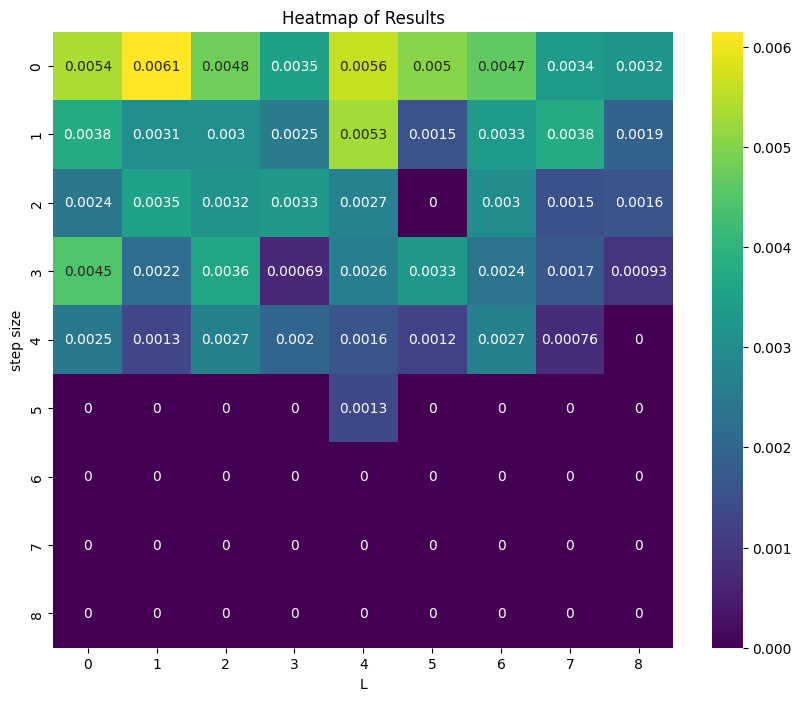

In [9]:
import seaborn as sns

import matplotlib.pyplot as plt

# Extract x and y values from the keys of the results dictionary
# x_values = [key[0] for key in results.keys()]
# y_values = [key[1] for key in results.keys()]

# print(len(x_values))
# raise Exception

# Extract heat values from the dictionary
heat_values = list(x[0] for x in results.values())

print(np.array(heat_values).shape)
# Reshape the heat values into a 2D array
# heat_array = np.array(heat_values).reshape((len(x_values), len(y_values)))
heat_array = np.array(heat_values).reshape((9,9))
# bar = np.array(list(results.keys())).reshape((5,5,3))
# print(bar)
# print(np.array(heat_values).shape)
# print(np.array(results.keys()).shape)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heat_array, annot=True, cmap='viridis')
plt.xlabel('L')
plt.ylabel('step size')
plt.title('Heatmap of Results')
plt.show()


In [11]:
[(results[k][0], k) for k in results]

[(0.005370330065488815, ('banana', 1.1170037, 10.743564999999998)),
 (0.006148216780275106, ('banana', 1.1170037, 12.776323938494208)),
 (0.004798795096576214, ('banana', 1.1170037, 15.193695331236901)),
 (0.0035045745316892862, ('banana', 1.1170037, 18.068450591090546)),
 (0.0056139081716537476, ('banana', 1.1170037, 21.48713)),
 (0.005047785583883524, ('banana', 1.1170037, 25.55264787698842)),
 (0.004653009120374918, ('banana', 1.1170037, 30.387390662473805)),
 (0.0033744920510798693, ('banana', 1.1170037, 36.1369011821811)),
 (0.0032409471459686756, ('banana', 1.1170037, 42.97426000000001)),
 (0.003767257323488593, ('banana', 1.328348747524365, 10.743564999999998)),
 (0.003065141150727868, ('banana', 1.328348747524365, 12.776323938494208)),
 (0.0030377914663404226, ('banana', 1.328348747524365, 15.193695331236901)),
 (0.002538589294999838, ('banana', 1.328348747524365, 18.068450591090546)),
 (0.005329370032995939, ('banana', 1.328348747524365, 21.48713)),
 (0.0015453267842531204, ('

(225,)


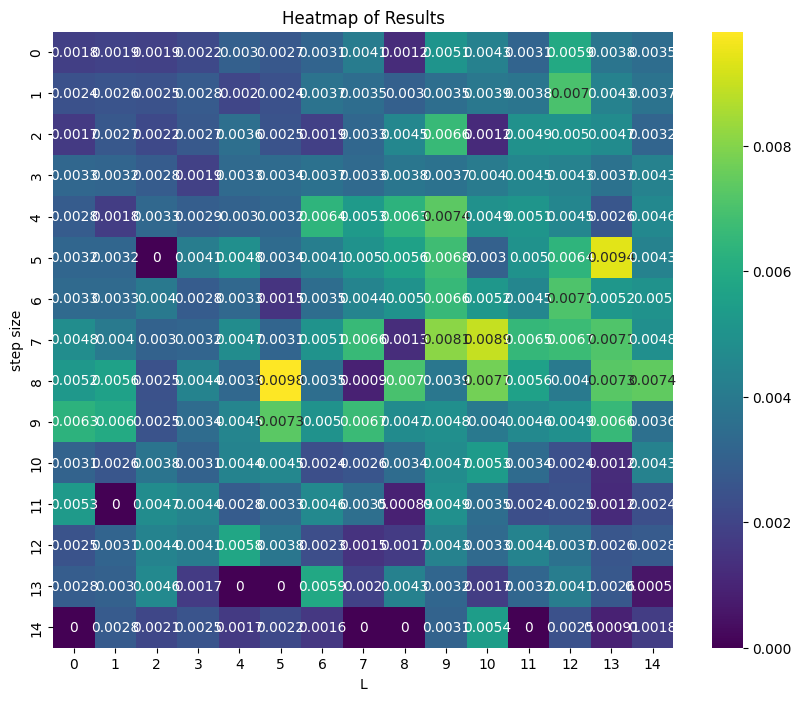

In [3]:
import seaborn as sns

import matplotlib.pyplot as plt

# Extract x and y values from the keys of the results dictionary
# x_values = [key[0] for key in results.keys()]
# y_values = [key[1] for key in results.keys()]

# print(len(x_values))
# raise Exception

# Extract heat values from the dictionary
heat_values = list(x[0] for x in results.values())

print(np.array(heat_values).shape)
# Reshape the heat values into a 2D array
# heat_array = np.array(heat_values).reshape((len(x_values), len(y_values)))
heat_array = np.array(heat_values).reshape((15,15))
# bar = np.array(list(results.keys())).reshape((5,5,3))
# print(bar)
# print(np.array(heat_values).shape)
# print(np.array(results.keys()).shape)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heat_array, annot=True, cmap='viridis')
plt.xlabel('L')
plt.ylabel('step size')
plt.title('Heatmap of Results')
plt.show()


(225,)


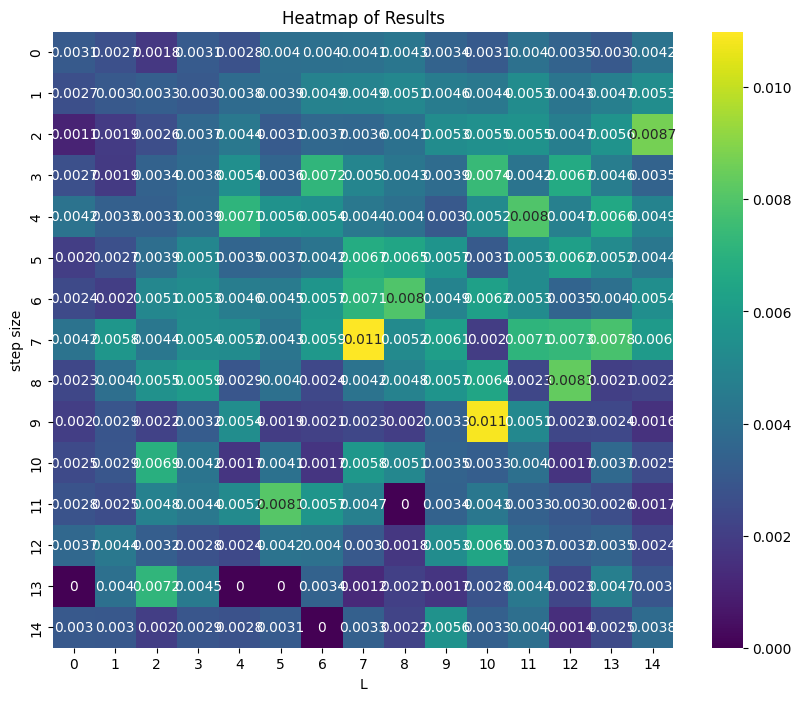

(225,)


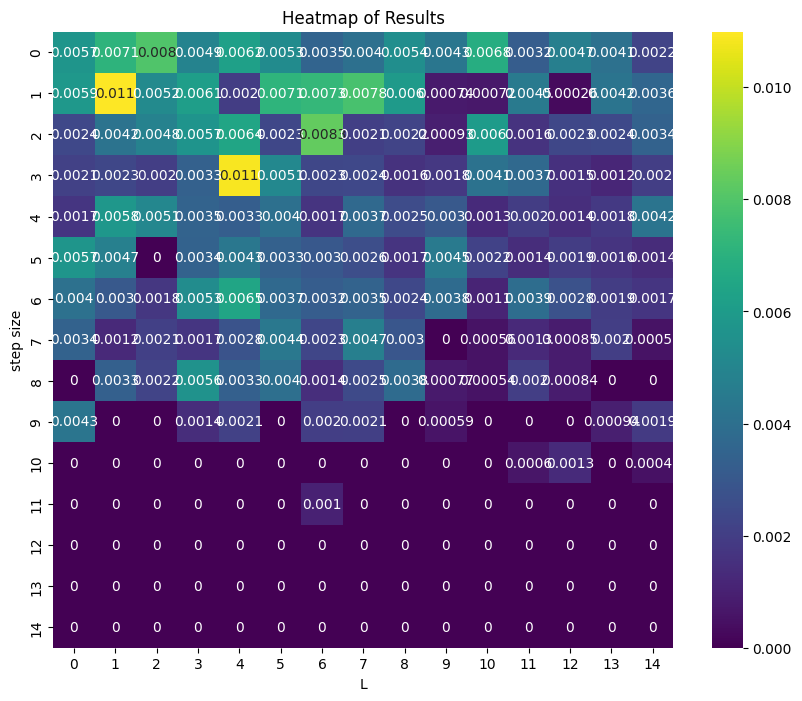

In [4]:
[(results[k][0], k) for k in results]

[(0.005712613929063082, ('banana', 1.1170037, 10.743564999999998)),
 (0.007112362887710333, ('banana', 1.1170037, 11.86185745597299)),
 (0.007971017621457577, ('banana', 1.1170037, 13.096552429833302)),
 (0.004914065357297659, ('banana', 1.1170037, 14.459766203058242)),
 (0.006202687509357929, ('banana', 1.1170037, 15.964876234971603)),
 (0.005263301078230143, ('banana', 1.1170037, 17.6266524381324)),
 (0.003495484357699752, ('banana', 1.1170037, 19.46140211811492)),
 (0.004011171869933605, ('banana', 1.1170037, 21.48713)),
 (0.0053871674463152885, ('banana', 1.1170037, 23.723714911945983)),
 (0.004298885352909565, ('banana', 1.1170037, 26.193104859666608)),
 (0.0068483250215649605, ('banana', 1.1170037, 28.91953240611649)),
 (0.0032153637148439884, ('banana', 1.1170037, 31.92975246994321)),
 (0.004687141161412001, ('banana', 1.1170037, 35.25330487626481)),
 (0.004053379409015179, ('banana', 1.1170037, 38.922804236229844)),
 (0.0022215722128748894, ('banana', 1.1170037, 42.974260000000

In [51]:

# results[('Banana', np.linspace(1,3,10)[1], np.linspace(12,16,10)[4])]
# results_1 = {results[key]: key for key in results.keys() if type(results[key]) is tuple}
# max(results_1, key=lambda x: results_1[x][0])
max([(results[r][0], r) for r in results if type(results[r]) is tuple])


(0.029569892212748528, ('Banana', 1.2222222222222223, 13.777777777777779))